# <center> <font color="royalblue"> Project Overview </font>

#### Research Question

Given the importance of future earnings as a factor in college selection and as an indicator of college quality, it is important to understand what institutional and student characteristics are important in determining students’ future earnings. Specifically:
<br>
<br>
<font color="royalblue"> ***What institutional and student characteristics are the most important predictors of students’ future earnings being in the top 25% (of earnings across all colleges)?***

For the purpose of this project, only **currently operating**, **4-year institutions** will be considered. 
<br>
A separate analysis for private non-profit institutions would also be made.

**Data Source**
<br>
College Scorecard Data

Citation:
<br>
U.S. Department of Education. (2021a). College Scorecard Data. Office of Planning, Evaluation and Policy Development (OPEPD). 
<a href="https://collegescorecard.ed.gov/data/documentation/">https://collegescorecard.ed.gov/data/documentation/</a>

# <center> <font color="royalblue"> Data Acquisition </font>

The College Scorecard API was used to obtain data and saved as a csv file. So one can also simply load in the dataset (in code chunk 11). 

In [1]:
# import required packages
import requests
import json
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

# sklearn
from sklearn.model_selection import cross_val_score, validation_curve, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score
warnings.filterwarnings("ignore")
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
import eli5 # "explain it to me like I'm 5"
from eli5.sklearn import PermutationImportance
import sklearn.metrics as m
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn import tree # For plotting the decision tree rules

import scipy.stats
import missingno as miss
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
from pandas.api.types import CategoricalDtype # Ordering categories
from statsmodels.stats.outliers_influence import variance_inflation_factor


Guidance to use College Scorecard API obtained from:
- https://github.com/RTICWDT/open-data-maker/blob/master/API.md
- https://github.com/kiseki1107/College-Scorecard-Data-Analysis

In [2]:
# store API key
api_key = "WRPivGGLhMXq5weo5ot1ZH3Z1LnVhYI6pwU0XDfU"

In [3]:
# Review
base_url = "https://api.data.gov/ed/collegescorecard/v1/schools?"
base_url = f"{base_url}api_key={api_key}&fields="
base_url

'https://api.data.gov/ed/collegescorecard/v1/schools?api_key=WRPivGGLhMXq5weo5ot1ZH3Z1LnVhYI6pwU0XDfU&fields='

In [4]:
# Select only currently operating institutions
parameters = ["&school.operating=1"]

# Create parameters_url
parameters_url = ""
for parameter in parameters:
    parameters_url = parameters_url + parameter
parameters_url

'&school.operating=1'

Comments in front of every field in the code chunk below include a short description of the variable being obtained. These are also listed below:

**Variables to keep**:
<br>

- `OPEID6` (6-digit OPE ID for institution)
- `STATE` (State)
- `CONTROL` (Control of institution; 1 = Public, 2 = Private nonprofit, 3 = Private for profit)
- `ADM_RATE` (Overall Admission Rate)
*since colleges accept both SAT and ACT scores, I will consider only SAT scores in my analysis*
- `SAT_AVG` (Average SAT equivalent score of students admitted)
- `COSTT4_A` (Average cost of attendance (academic year institutions))
- `AVGFACSAL` (Average Faculty Salary)
- `PFTFAC` (Proportion of faculty that is full-time)
- `UG25ABV` (Percentage of undergraduates aged 25 and above)
- `DEP_STAT_PCT_IND` (Percentage of students who are financially independent)
- `GRAD_DEBT_MDN` (The median debt for students who have completed)
- `AGE_ENTRY` (Average age of entry)
- `FEMALE` (Share of female students)
- `MARRIED` (Share of married students)
- `DEPENDENT` (Share of dependent students)
- `FIRST_GEN` (Share of first generation students)
- `MEDIAN_HH_INC` (Median Household Income)
- `MD_EARN_WNE_P10` (Median earnings of students working and not enrolled 10 years after entry)
- `ICLEVEL` (Level of institution; 1 = 4-year, 2 = 2-year, 3 = less than 2-year)
- `RET_FT4_POOLED` (First-time, full-time student retention rate at four-year institutions)
- `C100_4_POOLED` (Completion rate for first-time, full-time students at four-year institutions (100% of expected time to completion), pooled for rolling averages)

In [5]:
# Select fields
year = "latest"
fields = {
          # School Category
          "STATE": "school.state",
          "CONTROL": "school.ownership", # school ownership
          "PFTFAC": "school.ft_faculty_rate", # Proportion of faculty that is full-time
          "AVGFACSAL": "school.faculty_salary", # average faculty salary
          "ICLEVEL": "school.institutional_characteristics.level", # level of institution
    
          # ID
          "OPEID6": "ope6_id", # 6-digit OPE ID for Institution
    
          # Student Category
          "UG25ABV": year + ".student.share_25_older", # Percentage of undergraduates aged 25 and above
          "DEP_STAT_PCT_IND": year + ".student.share_independent_students", # share of financially indep students
          "DEPENDENT": year + ".student.demographics.dependent", # share of dependent students
          "FEMALE": year + ".student.demographics.female_share", # share of female students
          "RET_FT4_POOLED": year + ".student.retention_rate.four_year.full_time", # retention rate
          "AGE_ENTRY": year + ".student.demographics.age_entry", # average age of entry
          "MARRIED": year + ".student.demographics.married", # share of married students
          "FIRST_GEN": year + ".student.demographics.first_generation", # share of first generation students
          "MEDIAN_HH_INC": year + ".student.demographics.median_hh_income", # median household income
    
          # Cost Category
          "COSTT4_A": year + ".cost.attendance.academic_year", # average cost of attendance
          
          # Completion Category
          "C100_4_POOLED": year + ".completion.completion_rate_four_year_100_pooled", # completion rate
    
          # Admissions Category 
          "ADM_RATE": year + ".admissions.admission_rate.overall", # admission rate
          "SAT_AVG": year + ".admissions.sat_scores.average.overall", # SAT average
    
          # Aid Category
          "GRAD_DEBT_MDN": year + ".aid.median_debt.completers.overall", # median debt of students who have completed
         
          # Earnings Category
          "MD_EARN_WNE_P10": year + ".earnings.10_yrs_after_entry.median" # Median earnings of students working and not
                                                                          #enrolled 10 years after entry
    
         }

# Append fields to create fields_url
fields_url = ""
for key, val in fields.items():
    fields_url = fields_url + val + ","

# Remove the extra "," at the end of fields_url
fields_url = fields_url[:-1]
fields_url

'school.state,school.ownership,school.ft_faculty_rate,school.faculty_salary,school.institutional_characteristics.level,ope6_id,latest.student.share_25_older,latest.student.share_independent_students,latest.student.demographics.dependent,latest.student.demographics.female_share,latest.student.retention_rate.four_year.full_time,latest.student.demographics.age_entry,latest.student.demographics.married,latest.student.demographics.first_generation,latest.student.demographics.median_hh_income,latest.cost.attendance.academic_year,latest.completion.completion_rate_four_year_100_pooled,latest.admissions.admission_rate.overall,latest.admissions.sat_scores.average.overall,latest.aid.median_debt.completers.overall,latest.earnings.10_yrs_after_entry.median'

In [6]:
## determine page range

# access and parse
url = f"{base_url}{fields_url}{parameters_url}"
schools = requests.get(url).json()

# store total results
total = schools['metadata']['total']

# store results per_page
per_page = schools['metadata']['per_page']

# pages to parse
pages = round(total/per_page)+2

Note: the code chunk below takes quite a few minutes to run.

In [7]:
# Create empty list to hold responses
df_orig = []

# Iterate through all 324 pages 
for x in range(0,pages): 
    query_url = f"{base_url}{fields_url}{parameters_url}&page={x}"
    response = requests.get(query_url).json()
    
    for y in range(len(response["results"])):
        result_row = {}
        
        for key, val in fields.items(): 
            try:
                result_row[key] = response["results"][y][val]
            except KeyError:
                print(f"{key} key not found")
                
        df_orig.append(result_row)

        
df_orig = pd.DataFrame(df_orig)

In [8]:
# check shape
df_orig.shape

(6469, 21)

In [9]:
# view data
df_orig.head(5)

,STATE,CONTROL,PFTFAC,AVGFACSAL,ICLEVEL,OPEID6,UG25ABV,DEP_STAT_PCT_IND,DEPENDENT,FEMALE,...,AGE_ENTRY,MARRIED,FIRST_GEN,MEDIAN_HH_INC,COSTT4_A,C100_4_POOLED,ADM_RATE,SAT_AVG,GRAD_DEBT_MDN,MD_EARN_WNE_P10
0,AL,1,0.7411,7101.0,1,001002,0.0758,0.098870,0.901130,0.564030,...,20.0,0.009102,0.365828,49720.0,22489.0,0.0464,0.8986,957.0,33375.0,31000.0
1,AL,1,0.7766,10717.0,1,001052,0.2296,0.321409,0.678591,0.639091,...,23.0,0.105087,0.341224,55735.0,24347.0,0.3324,0.9211,1220.0,22500.0,41200.0
2,AL,2,1.0000,4292.0,1,025034,0.8302,0.895270,0.104730,0.648649,...,33.0,0.236486,0.512500,53683.0,17680.0,0.1786,NaN,NaN,27334.0,39600.0
3,AL,1,0.6544,9442.0,1,001055,0.1842,0.251570,0.748430,0.476350,...,22.0,0.100460,0.310132,58688.0,23441.0,0.2234,0.8087,1314.0,21607.0,46700.0
4,AL,1,0.5826,7754.0,1,001005,0.0848,0.107428,0.892572,0.613419,...,20.0,0.007987,0.343434,46065.0,21476.0,0.1042,0.9774,972.0,32000.0,27700.0


In [10]:
# save data - store as csv 
#df_orig.to_csv(r'C:\Georgetown University\Courses\Spring Semester 2021\PPOL 565 – 01 - Data Science II App Stat Lng\Project\college_scorecard.csv', index = False)

Can use the code chunk below to simply load in the dataset (from the zip file) instead of obtaining it through the API.

Note: remove the hashtag before the code to run it. 

In [11]:
# load in data
#df_orig = pd.read_csv('college_scorecard.csv')

# <center> <font color="royalblue"> Data Characterization </font>

**Missing values**

In [12]:
# check missingness
df_orig.isnull().sum()

STATE                  0
CONTROL                0
PFTFAC              2886
AVGFACSAL           2546
ICLEVEL                0
OPEID6                 0
UG25ABV              869
DEP_STAT_PCT_IND     982
DEPENDENT            982
FEMALE              1406
RET_FT4_POOLED      4410
AGE_ENTRY            602
MARRIED             1414
FIRST_GEN           1258
MEDIAN_HH_INC       1960
COSTT4_A            3107
C100_4_POOLED       4447
ADM_RATE            4494
SAT_AVG             5182
GRAD_DEBT_MDN       1423
MD_EARN_WNE_P10     1874
dtype: int64

In the original, raw dataset, missingness is denoted both by NaN values. The dataset contains many missing values across the variables of interest e.g. `SAT_AVG` (variable measuring average SAT scores) has the most missing values (more than 80%), while other variables such as `ADM_RATE` (variable measuring overall admission rate) also have significant missingness. The outcome variable (Median earnings of students working and not enrolled 10 years after entry) has around 29% missing values. 

**Dimensionality**

There are 21 attributes corresponding to 6469 rows.

**Resolution**

The level at which each attribute is observed is a single educational institution i.e. at the unit level. In other words, the unit of analysis is educational institutions. 

**Attribute Types**

There are binary, discrete as well as continuous attributes in the data, and some attributes are qualitative (categorical and nominal) while some are quantitative (interval and ratio). For instance, the control of the institution (`CONTROL`), the level of the institution (`ICLEVEL`) and the state the institution is located in (`STATE`) are all discrete, categorical (qualitative) nominal attributes. The entry age of students is a discrete and quantitative (ratio) variable while most other variables, such as the overall admission rate and the share of female students are all continuous and quantitative (ratio) variables.

In [13]:
# create copy
df = df_orig.copy()

In [14]:
# check shape
df.shape

(6469, 21)

# <center> <font color="royalblue"> High Level Preprocessing </font>

According to the <a href="https://collegescorecard.ed.gov/assets/FieldOfStudyDataDocumentation.pdf">technical documentation of the College Scorecard</a>, the Office of Postsecondary Education ID number (`OPEID6`) represents the main campus (and all of its branches) of a multi-branch institution. 

_"Scorecard uses this aggregated approach to calculate cumulative debt and post-completion earnings data because not all institutions report information needed to calculate these metrics at the more granular branch location level. For institutions with multiple UNITIDs (branches) that map to the same six-digit OPEID (main campus), data calculated at the aggregated OPEID6-level are repeated across any branches that offer those fields of study based on IPEDS Completions component reporting."_

Therefore, `OPEID6` would be used as the unit of analysis, and to remove duplicates.

In [15]:
# check for duplicates
ids = df["OPEID6"]
df[ids.isin(ids[ids.duplicated()])].head(2)

,STATE,CONTROL,PFTFAC,AVGFACSAL,ICLEVEL,OPEID6,UG25ABV,DEP_STAT_PCT_IND,DEPENDENT,FEMALE,...,AGE_ENTRY,MARRIED,FIRST_GEN,MEDIAN_HH_INC,COSTT4_A,C100_4_POOLED,ADM_RATE,SAT_AVG,GRAD_DEBT_MDN,MD_EARN_WNE_P10
12,AL,3,0.1467,5304.0,1,013039,0.6206,0.784843,0.215157,0.762867,...,30.0,0.236708,0.472288,55764.0,29309.0,0.0208,NaN,NaN,25166.0,33400.0
21,AL,2,0.5556,5988.0,1,009621,0.7598,0.859247,0.140753,0.813547,...,31.0,0.231273,0.520903,46871.0,26128.0,0.1111,0.95,NaN,22730.0,37800.0


In [16]:
# drop duplicates of OPEID6, keeping only the first instance. 
df.drop_duplicates(subset ="OPEID6",
                     keep = "first", inplace = True)
# check shape 
df.shape

(5183, 21)

In [17]:
# check for missing values
#df.isnull().sum()

Keep only **4-year institutions**

In [18]:
# keep only those rows that correspond to currently operating 4-year institutions 
df = df[df.ICLEVEL == 1]

# check new shape of data
df.shape

(2416, 21)

In [19]:
# check missingness again
#df.isnull().sum()

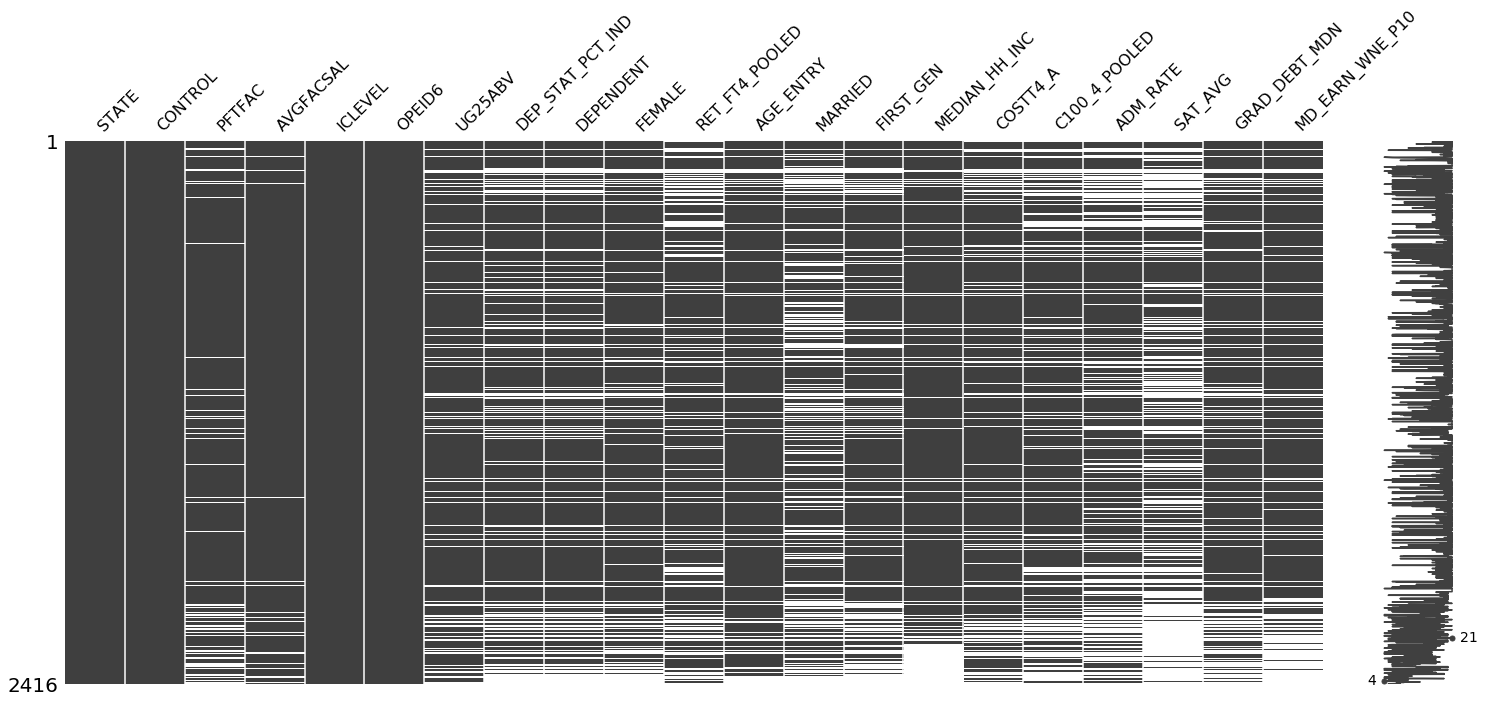

In [20]:
# visualize missing data
miss.matrix(df)

Since there are significant missing values in the `SAT_AVG` variable (50% missing), and since this variable is important for analysis, only those institutions in the final dataset that have values for this variable available would be kept. Doing so would remove many observations which could potentially cause the models run to miss out on valuable information available from
the non-missing values in the rows where `SAT_AVG` is missing. However, as can be seen in the visualization of missingness above, many institutions that do not have their average SAT scores reported also have missing data on other variables such as average faculty salary and average cost of attendance. Moreover, missing SAT scores are not being imputed since imputing missing SAT scores would result in as many imputed values as observed values, which may impact the performance of the machine learning models used ahead. 

In [21]:
# remove rows where SAT_AVG is not available
df = df[df['SAT_AVG'].notna()]

# check shape of data
df.shape

(1209, 21)

In [22]:
# check for missingness again
df.isnull().sum()

STATE                 0
CONTROL               0
PFTFAC                7
AVGFACSAL             3
ICLEVEL               0
OPEID6                0
UG25ABV               3
DEP_STAT_PCT_IND     76
DEPENDENT            76
FEMALE               39
RET_FT4_POOLED        7
AGE_ENTRY            12
MARRIED             250
FIRST_GEN            55
MEDIAN_HH_INC        30
COSTT4_A             10
C100_4_POOLED        14
ADM_RATE              0
SAT_AVG               0
GRAD_DEBT_MDN        22
MD_EARN_WNE_P10      40
dtype: int64

In this reduced dataset, there are significantly less missing values than before. Moreover, in variables that do have some missing values e.g. `MEDIAN_HH_INC` and `FIRST_GEN`, these missing values make up a very small percentage of the total values. The variable with the most missing values, `MARRIED`, has 21% missing values. Missing data would be imputed by replacing missing observations with the mean value of the respective variables.

**Check Data Types and Explore Data**

In [23]:
# check data types
df.dtypes

STATE                object
CONTROL               int64
PFTFAC              float64
AVGFACSAL           float64
ICLEVEL               int64
OPEID6               object
UG25ABV             float64
DEP_STAT_PCT_IND    float64
DEPENDENT           float64
FEMALE              float64
RET_FT4_POOLED      float64
AGE_ENTRY           float64
MARRIED             float64
FIRST_GEN           float64
MEDIAN_HH_INC       float64
COSTT4_A            float64
C100_4_POOLED       float64
ADM_RATE            float64
SAT_AVG             float64
GRAD_DEBT_MDN       float64
MD_EARN_WNE_P10     float64
dtype: object

In [24]:
# view states
df.STATE.unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR'], dtype=object)

In [25]:
# view total number of states
len(df.STATE.unique()) #50 states + DC and PR  

52

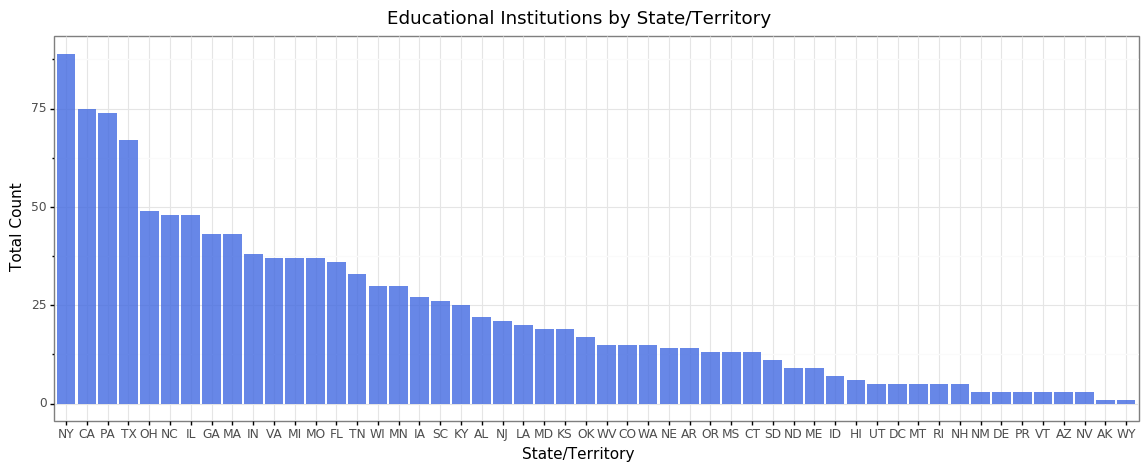

<ggplot: (-9223371866677568360)>

In [26]:
### plot state frequency

# create df for states
states = df[['STATE','OPEID6']]
states
states = states.groupby('STATE').count().reset_index().rename(columns={'OPEID6':"obs"})
states.sort_values(by=['obs'], inplace=True, ascending=False)

# create list of state names
state_list = list(states.STATE.values)

# plot
plot_states = (ggplot(states, aes(x=state_list,y="obs"))+
geom_bar(stat = "identity",position="dodge",show_legend=False,fill="royalblue",alpha=0.8)+
labs(x="State/Territory",y="Total Count", title="Educational Institutions by State/Territory")+
 theme_bw()+
 scale_x_discrete(limits = state_list)+
 theme(figure_size=(14, 5)
))

# save plot
plot_states.save("plot_states.png", width=14, height=5, dpi=300)

# view plot
plot_states

The highest number of educational institutions is in New York, followed closely by California, Pennsylvania and Texas, whereas the lowest are in Alaska and Wyoming. 

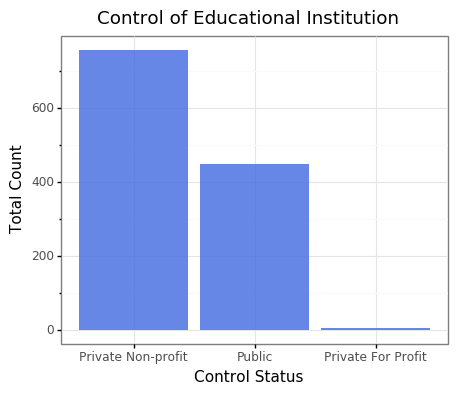

<ggplot: (-9223371866677628908)>

In [27]:
### plot control of institution

# label encoded values
control_df = df.copy()
control_df["CONTROL"].replace({1: "Public", 2: "Private Non-profit", 3:"Private For Profit"}, inplace=True)

# create list of CONTROL categories
control_list = ["Private Non-profit", "Public", "Private For Profit"]

# plot
plot_control = (ggplot(control_df, aes(x='factor(CONTROL)'))+
geom_bar(show_legend=False,fill="royalblue",alpha=0.8,position="dodge")+
labs(x='Control Status',y="Total Count", title="Control of Educational Institution")+
 theme_bw()+
 scale_x_discrete(limits = control_list)+
 theme(figure_size=(5, 4)
))

# save plot
plot_control.save("plot_control.png", width=5, height=4, dpi=300)

# view plot
plot_control

The dataset comprises of both public and private educational institutions, with the fewest observations from for-profit private institutions. This low number may be because of the impact of the Gainful Employment (GE) Rule of 2014 – even though GE has now been rescinded, it caused some for-profit colleges to go out of business and others to apply to become nonprofit institutions <a href="https://www.franklin.edu/blog/non-profit-vs-for-profit-colleges-what-you-need-to-know">(Franklin University, n.d.)</a>.




In [28]:
# fill missing values with mean column values (since categorical vars have no missingness, this does not affect them)
df.fillna(df.mean(), inplace=True)

In [29]:
# check missingness again
df.isnull().sum()

STATE               0
CONTROL             0
PFTFAC              0
AVGFACSAL           0
ICLEVEL             0
OPEID6              0
UG25ABV             0
DEP_STAT_PCT_IND    0
DEPENDENT           0
FEMALE              0
RET_FT4_POOLED      0
AGE_ENTRY           0
MARRIED             0
FIRST_GEN           0
MEDIAN_HH_INC       0
COSTT4_A            0
C100_4_POOLED       0
ADM_RATE            0
SAT_AVG             0
GRAD_DEBT_MDN       0
MD_EARN_WNE_P10     0
dtype: int64

Convert the following variables to categorical variables:
- `OPEID6`
- `ICLEVEL`
- `CONTROL`  
- `STATE`  

*Note: None of these categorical variables contain missing values.*

The first 2 variables will be changed to Categorical variable types but no dummies would be created since `ICLEVEL` has only one value while `OPEID6` has as many unique values as there are rows. 

Dummies would be created for `CONTROL` and `STATE` since both these variables will be used as predictors in the machine learning models. 

In [30]:
# Convert into categorical variables
df['OPEID6'] = pd.Categorical(df['OPEID6'])
df['ICLEVEL'] = pd.Categorical(df['ICLEVEL'])

In [31]:
# check control variable
df['CONTROL'].unique()

array([1, 2, 3], dtype=int64)

In [32]:
# label encoded values to improve readability
df["CONTROL"].replace({1: "Public", 2: "Private_Non_profit", 3:"Private_For_Profit"}, inplace=True)

# check control variable again
df['CONTROL'].unique()

array(['Public', 'Private_Non_profit', 'Private_For_Profit'], dtype=object)

In [33]:
# convert state and control variables to dummy variables
df = pd.get_dummies(df, columns=['STATE', 'CONTROL'], drop_first=True)

# check df
df.head(2)

,PFTFAC,AVGFACSAL,ICLEVEL,OPEID6,UG25ABV,DEP_STAT_PCT_IND,DEPENDENT,FEMALE,RET_FT4_POOLED,AGE_ENTRY,...,STATE_TX,STATE_UT,STATE_VA,STATE_VT,STATE_WA,STATE_WI,STATE_WV,STATE_WY,CONTROL_Private_Non_profit,CONTROL_Public
0,0.7411,7101.0,1,001002,0.0758,0.098870,0.901130,0.564030,0.6087,20.0,...,0,0,0,0,0,0,0,0,0,1
1,0.7766,10717.0,1,001052,0.2296,0.321409,0.678591,0.639091,0.8186,23.0,...,0,0,0,0,0,0,0,0,0,1


In [34]:
# check shape
df.shape

(1209, 72)

## <center> <font color="royalblue"> Graphical Summaries </font>

**Check outcome variable**

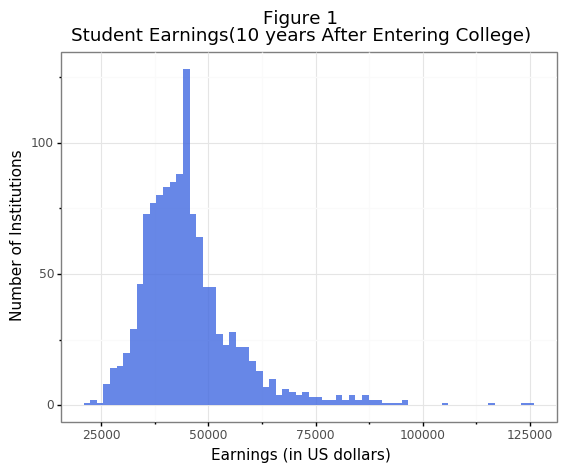

<ggplot: (-9223371866676820620)>

In [35]:
# plot
plot_outcome = (ggplot(df, aes(x = 'MD_EARN_WNE_P10')) +
  geom_histogram(fill="royalblue",alpha=0.8, bins=68) +
                scale_x_continuous() +
 labs(title="Figure 1\nStudent Earnings(10 years After Entering College)", x="Earnings (in US dollars)",y="Number of Institutions") +
 theme(figure_size=(10, 6))+
 theme_bw())

# save plot
plot_outcome.save("plot_outcome.png", width=10, height=6, dpi=300)

# view plot
plot_outcome

Plot completion rates and cost of attendance

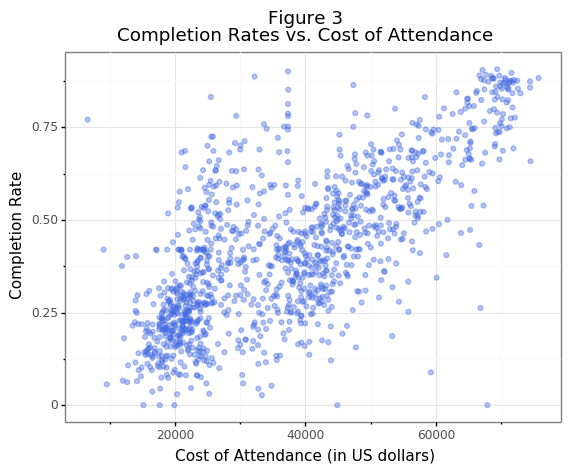

<ggplot: (-9223371866676747620)>

In [36]:
# plot
plot_costcompletion = (ggplot(df,aes(x='COSTT4_A',y='C100_4_POOLED'))
    + geom_point(alpha=0.4,color="royalblue") 
 + labs(title="Figure 3\nCompletion Rates vs. Cost of Attendance",
        x="Cost of Attendance (in US dollars)",y="Completion Rate") +
 theme(figure_size=(10, 6))
 +theme_bw()
 
)

# save plot
plot_costcompletion.save("plot_costcompletion.png", width=10, height=6, dpi=300)

# view plot
plot_costcompletion

## <center> <font color="royalblue"> Data Characterization (Final Dataset) </font>

**Missing values**

In the original, raw dataset, missingness was denoted by NaN values. The dataset contained many missing values across the variables of interest e.g. `SAT_AVG` (variable measuring average SAT scores) had more than 80% missing values, and the outcome variable (Median earnings of students working and not enrolled 10 years after entry) had around 29% missing values. 

After reducing the dataset to include only currently operating, four-year institutions, the missingness problem remained, although it was less severe e.g. `SAT_AVG` had 50% missing values in the reduced dataset. Since this variable had the highest share of missing values, and since imputing its missing values would have resulted in as many imputed values as actual observations, rows containing missing values of `SAT_AVG` were dropped from the dataset. This significantly reduced missingness, with the most missingness in a variable being 21% while missing data in other variables was much lower. These missing values were replaced with the mean of the respective variables.

**Dimensionality**

Inlcuding the dummy variables created from categorical variables, there are 72 attributes corresponding to 1209 rows. 

**Attribute Types**

There are binary, discrete as well as continuous attributes in the data, and some attributes are qualitative (categorical and nominal) while some are quantitative (interval and ratio). For instance, the control of the institution (`CONTROL`), the level of the institution (`ICLEVEL`) and the state the institution is located in (`STATE`) are all discrete, categorical (qualitative) nominal attributes. The entry age of students is a discrete and quantitative (ratio) variable while most other variables, such as the overall admission rate and the share of female students are all continuous and quantitative (ratio) variables.

**Resolution**

The level at which each attribute is observed is a single educational institution i.e. at the unit level. In other words, the unit of analysis is educational institutions. 

**Potential multicollinearity**

Correlation is a statistical measure that indicates the extent to which two or more variables move together¹, whereas multicollinearity is when two or more predictors are highly linearly related. In general, an absolute correlation coefficient that is greater than 0.7 indicates the presence of multicollinearity².

There could be potential multicollinearity between a few attributes such as between the median debt of students who have completed their degrees (`GRAD_DEBT_MDN`) and the average cost of the program (`COSTT4_A`) such that higher average costs would result in higher debt levels. There may also be multicollinearity between the average age of entry (`AGE_ENTRY`) and the percentage of students who are financially independent (`DEP_STAT_PCT_IND`) as older students are more likely to financially independent. Moreover, since the percentage of undergraduates aged 25 and above (`UG25ABV`) is linked to the age of entry (`AGE_ENTRY`), these two variables may be multicollinear.

However, such multicollinearity would not cause bias, but it would cause the standard errors of  $\hat{\beta}_{1}$ to be greater than if there were no multicollinearity. In addition to these assumptions about possible multicollinearity, it is helpful to look at the actual correlation (calculated below) between variables since we have the data available, as well as to detect multicollinearity using Variance Inflation Factor (VIF). 

¹Ivy Wigmore., (November, 2016): Correlation. Retrieved from-https://www.mckinsey.com/industries/high-tech/our-insights/an-executives-guide-to-machine-learning

²Elon Correa and Royston Goodacre., (Janury, 2011): A genetic algorithm-Bayesian network approach for the analysis of metabolomics and spectroscopic data: application to the rapid identification of Bacillus spores and classification of Bacillus species. Retrieved from- https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-12-33

In [37]:
# look at correlation
corr = df.corr(method='pearson')
corr = corr.unstack()
corr[(corr >= 0.7) & (corr != 1.000000)]

AVGFACSAL                   SAT_AVG                       0.713899
UG25ABV                     DEP_STAT_PCT_IND              0.871804
                            AGE_ENTRY                     0.882138
DEP_STAT_PCT_IND            UG25ABV                       0.871804
                            AGE_ENTRY                     0.942150
                            MARRIED                       0.791252
RET_FT4_POOLED              SAT_AVG                       0.769276
AGE_ENTRY                   UG25ABV                       0.882138
                            DEP_STAT_PCT_IND              0.942150
                            MARRIED                       0.761891
MARRIED                     DEP_STAT_PCT_IND              0.791252
                            AGE_ENTRY                     0.761891
COSTT4_A                    C100_4_POOLED                 0.720124
                            CONTROL_Private_Non_profit    0.727557
C100_4_POOLED               COSTT4_A                      0.72

`AGE_ENTRY`, and `DEP_STAT_PCT_IND` and `UG25ABV` are highly correlated. Moreover, the share of students who are married (`MARRIED`) is correlated with the share of students who are financially independent (`DEP_STAT_PCT_IND`) as well as the average age of entry. The retention and completion rates are highly correlated with average SAT scores. There is also high correlation between the completion rate and the average cost of the program, as well as the average cost of the program and private non-profit institutions. 

In [38]:
### Detecting multicollinearity

# the independent variables set
X = df[['ADM_RATE', 'SAT_AVG', 'COSTT4_A', 'AVGFACSAL', 'PFTFAC', 'UG25ABV',
         'DEP_STAT_PCT_IND', 'GRAD_DEBT_MDN', 'AGE_ENTRY', 'FEMALE', 'MARRIED', 'DEPENDENT',
         'FIRST_GEN', 'MEDIAN_HH_INC', 'MD_EARN_WNE_P10', 'RET_FT4_POOLED', 
         'C100_4_POOLED']] # all variables excluding OPEID6, STATE, ICLEVEL and CONTROL

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

             feature         VIF
0           ADM_RATE    1.437782
1            SAT_AVG    5.875937
2           COSTT4_A    3.159207
3          AVGFACSAL    3.528075
4             PFTFAC    1.188754
5            UG25ABV    5.902560
6   DEP_STAT_PCT_IND  201.813676
7      GRAD_DEBT_MDN    1.639248
8          AGE_ENTRY   11.238555
9             FEMALE    1.374716
10           MARRIED    3.596254
11         DEPENDENT  859.343940
12         FIRST_GEN    3.038664
13     MEDIAN_HH_INC    2.138939
14   MD_EARN_WNE_P10    2.552036
15    RET_FT4_POOLED    3.262988
16     C100_4_POOLED    4.131564


The percentage of students who are financially independent (`DEP_STAT_PCT_IND`) and the share of dependent students (`DEPENDENT`) have extremely high VIF values. This is expected as the more dependent students there are, the less the percentage of financially independent students would be. Hence, considering these two features together leads to a model with high multicollinearity. In order to bring down the multicollinearity, one of these features (`DEPENDENT`) will be dropped.  

In [39]:
# drop DEPENDENT
df = df.drop(columns = 'DEPENDENT')

In [40]:
### Detect multicollinearity again

# the independent variables set
X = df[['ADM_RATE', 'SAT_AVG', 'COSTT4_A', 'AVGFACSAL', 'PFTFAC', 'UG25ABV',
         'DEP_STAT_PCT_IND', 'GRAD_DEBT_MDN', 'AGE_ENTRY', 'FEMALE', 'MARRIED',
         'FIRST_GEN', 'MEDIAN_HH_INC', 'MD_EARN_WNE_P10', 'RET_FT4_POOLED', 
         'C100_4_POOLED']] # all variables excluding OPEID6, STATE, ICLEVEL and CONTROL + removed var

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

             feature         VIF
0           ADM_RATE   15.609959
1            SAT_AVG  343.471969
2           COSTT4_A   20.949144
3          AVGFACSAL   40.252152
4             PFTFAC   11.102908
5            UG25ABV   13.785219
6   DEP_STAT_PCT_IND   27.477267
7      GRAD_DEBT_MDN   47.956194
8          AGE_ENTRY  476.156552
9             FEMALE   39.404738
10           MARRIED   10.031056
11         FIRST_GEN   30.536430
12     MEDIAN_HH_INC   75.608312
13   MD_EARN_WNE_P10   41.457273
14    RET_FT4_POOLED  144.511642
15     C100_4_POOLED   20.783193


All variables have very high VIF values. This can lead to skewed or misleading results in a regression context, and therefore would be kept in mind while deciding which statistical models to use. 

In [41]:
# new shape
df.shape

(1209, 71)

# <center> <font color="royalblue"> Numerical Summaries  </font>

In [42]:
# create dataframe with quantitative variables (excluding dummy variables)
df_num = df[['ADM_RATE', 'SAT_AVG', 'COSTT4_A', 'AVGFACSAL',
       'PFTFAC', 'UG25ABV', 'DEP_STAT_PCT_IND', 'GRAD_DEBT_MDN', 'AGE_ENTRY',
       'FEMALE', 'MARRIED', 'FIRST_GEN', 'MEDIAN_HH_INC',
       'MD_EARN_WNE_P10', 'RET_FT4_POOLED', 'C100_4_POOLED']]

df_num.shape

(1209, 16)

In [43]:
# print descriptive statistics - round off to 2 decimal places
df_num1 = round(df_num.describe(include=['number']),2)
df_num1

,ADM_RATE,SAT_AVG,COSTT4_A,AVGFACSAL,PFTFAC,UG25ABV,DEP_STAT_PCT_IND,GRAD_DEBT_MDN,AGE_ENTRY,FEMALE,MARRIED,FIRST_GEN,MEDIAN_HH_INC,MD_EARN_WNE_P10,RET_FT4_POOLED,C100_4_POOLED
count,1209.00,1209.00,1209.00,1209.00,1209.00,1209.00,1209.00,1209.00,1209.00,1209.00,1209.00,1209.00,1209.00,1209.00,1209.00,1209.00
mean,0.66,1143.75,37339.10,8203.61,0.69,0.15,0.22,22988.95,21.65,0.58,0.08,0.31,64025.99,45474.42,0.76,0.42
std,0.21,125.98,15731.83,2502.96,0.24,0.13,0.15,4209.84,2.32,0.11,0.06,0.09,10838.81,11651.60,0.12,0.21
min,0.04,785.00,6646.00,1027.00,0.04,0.00,0.01,4833.00,19.00,0.12,0.01,0.09,20501.00,21100.00,0.11,0.00
25%,0.55,1059.00,23417.00,6576.00,0.51,0.05,0.10,20748.00,20.00,0.53,0.04,0.25,56756.00,38200.00,0.70,0.26
50%,0.68,1125.00,36371.00,7716.00,0.70,0.12,0.20,23335.00,21.00,0.58,0.08,0.31,63798.00,43600.00,0.77,0.40
75%,0.81,1204.00,48046.00,9443.00,0.92,0.22,0.28,26000.00,23.00,0.64,0.09,0.38,71862.00,49300.00,0.84,0.56
max,1.00,1566.00,75735.00,20484.00,1.00,0.68,0.80,37192.00,33.00,0.98,0.47,0.62,96737.00,124700.00,1.00,0.91


In [44]:
# frequency table for CONTROL 
control_tab = pd.crosstab(index=control_df["CONTROL"],  # Make a crosstab
                              columns="count")      # Name the count column

control_tab

col_0,count
CONTROL,
Private For Profit,5
Private Non-profit,756
Public,448


Create binary outcome variable such that top 25% earnings are coded as 1:
- 1 if `MD_EARN_WNE_P10` >= 49,300 
- 0 if `MD_EARN_WNE_P10` < 49,300 

Note: value of 49,300 is the 75th percentile of `MD_EARN_WNE_P10`

In [45]:
# create copy of df
df1 = df.copy()

# create a list of conditions
conditions = [
    (df1['MD_EARN_WNE_P10'] >= 49300),
    (df1['MD_EARN_WNE_P10'] < 49300)
    ]

# create a list of the to assign to each condition
values = ['1', '0']

# create a new column and use np.select to assign values to it using the lists as arguments
df1['earnings_25pct'] = np.select(conditions, values)

# display updated DataFrame
df1.head()

,PFTFAC,AVGFACSAL,ICLEVEL,OPEID6,UG25ABV,DEP_STAT_PCT_IND,FEMALE,RET_FT4_POOLED,AGE_ENTRY,MARRIED,...,STATE_UT,STATE_VA,STATE_VT,STATE_WA,STATE_WI,STATE_WV,STATE_WY,CONTROL_Private_Non_profit,CONTROL_Public,earnings_25pct
0,0.7411,7101.0,1,001002,0.0758,0.098870,0.564030,0.6087,20.0,0.009102,...,0,0,0,0,0,0,0,0,1,0
1,0.7766,10717.0,1,001052,0.2296,0.321409,0.639091,0.8186,23.0,0.105087,...,0,0,0,0,0,0,0,0,1,0
3,0.6544,9442.0,1,001055,0.1842,0.251570,0.476350,0.8288,22.0,0.100460,...,0,0,0,0,0,0,0,0,1,0
4,0.5826,7754.0,1,001005,0.0848,0.107428,0.613419,0.5868,20.0,0.007987,...,0,0,0,0,0,0,0,0,1,0
5,0.7454,10225.0,1,001051,0.0725,0.142965,0.615252,0.8788,21.0,0.053706,...,0,0,0,0,0,0,0,0,1,0


Check the balance of classes.

In [46]:
# check balance
earnings_25pct_tab = pd.crosstab(index=df1["earnings_25pct"],  # Make a crosstab
                              columns="count")      # Name the count column

earnings_25pct_tab

col_0,count
earnings_25pct,
0,906
1,303


303 observations are coded as 1 and 906 as 0, therefore the classes are unbalanced.

In [47]:
# reset index
df1 = df1.reset_index(drop=True)

# view df1
df1.head(5)

,PFTFAC,AVGFACSAL,ICLEVEL,OPEID6,UG25ABV,DEP_STAT_PCT_IND,FEMALE,RET_FT4_POOLED,AGE_ENTRY,MARRIED,...,STATE_UT,STATE_VA,STATE_VT,STATE_WA,STATE_WI,STATE_WV,STATE_WY,CONTROL_Private_Non_profit,CONTROL_Public,earnings_25pct
0,0.7411,7101.0,1,001002,0.0758,0.098870,0.564030,0.6087,20.0,0.009102,...,0,0,0,0,0,0,0,0,1,0
1,0.7766,10717.0,1,001052,0.2296,0.321409,0.639091,0.8186,23.0,0.105087,...,0,0,0,0,0,0,0,0,1,0
2,0.6544,9442.0,1,001055,0.1842,0.251570,0.476350,0.8288,22.0,0.100460,...,0,0,0,0,0,0,0,0,1,0
3,0.5826,7754.0,1,001005,0.0848,0.107428,0.613419,0.5868,20.0,0.007987,...,0,0,0,0,0,0,0,0,1,0
4,0.7454,10225.0,1,001051,0.0725,0.142965,0.615252,0.8788,21.0,0.053706,...,0,0,0,0,0,0,0,0,1,0


In [48]:
# check data types
#list(df1.dtypes)

In [49]:
# convert data type of outcome variable
convert_dict = {'earnings_25pct': float}
  
df1 = df1.astype(convert_dict)
#list(df1.dtypes)

Remove `OPEID6`, `MD_EARN_WNE_P10` and `ICLEVEL`

In [50]:
df1.drop('OPEID6', inplace=True, axis=1)
df1.drop('MD_EARN_WNE_P10', inplace=True, axis=1)
df1.drop('ICLEVEL', inplace=True, axis=1)

In [51]:
# check shape 
df1.shape

(1209, 69)

In [52]:
# rename some variables
df1.rename(columns={'SAT_AVG': 'Average SAT Score'}, inplace=True)
df1.rename(columns={'AVGFACSAL': 'Average Faculty Salary'}, inplace=True)
df1.rename(columns={'FEMALE': 'Share of Female Students'}, inplace=True)
df1.rename(columns={'RET_FT4_POOLED': 'Retention Rate'}, inplace=True)
df1.rename(columns={'MEDIAN_HH_INC': 'Median Household Income'}, inplace=True)
df1.rename(columns={'UG25ABV': 'Share of Students 25 and older'}, inplace=True)
df1.rename(columns={'C100_4_POOLED': 'Completion Rate'}, inplace=True)
df1.rename(columns={'PFTFAC': 'Full-time Faculty Proportion'}, inplace=True)
df1.rename(columns={'DEP_STAT_PCT_IND': 'Share of Financially Indep Students'}, inplace=True)
df1.rename(columns={'GRAD_DEBT_MDN': 'Median Debt'}, inplace=True)
df1.rename(columns={'COSTT4_A': 'Average Cost of Attendance'}, inplace=True)

## <center> <font color="royalblue"> Parametric Model: Logistic Lasso Regression

**Logistic LASSO regression**

Logistic regression makes some tweaks on linear regression by forcing the outcome to fall within the 0 to 1 range, and rearranging it so that it has a linear form, while LASSO is a shrinkage method. It works by adding a penalty term to the log likelihood function and selects from a set of variables in the regression, resulting in a more relevant and interpretable set of predictors (Tibshirani, 1996). In addition to being able to identify the most important predictors, logistic LASSO regression would also deal with the multicollinearity in the dataset, by selecting one of the multicollinear predictors (if it is important in determining the outcome) and shrinking the other one to zero. Moreover, outliers in the data will have less of an effect on logistic regression as compared to linear regression, since the logistic regression decision boundary only takes the points closer to it into consideration (outliers may still have an effect on the decision boundary however). As far as the issue of unbalanced classes affecting predictions, a few corrections will be tested.

-- Tibshirani, R. (1996). Regression Shrinkage and Selection Via the Lasso. Journal of the Royal Statistical Society: Series B (Methodological), 58(1), 267–288. https://doi.org/10.1111/j.2517-6161.1996.tb02080.x



#### Split dataset

In [53]:
y = df1[['earnings_25pct']]
X = df1.drop(columns=['earnings_25pct'])

# split data
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=123)

View distribution of continuous variables.

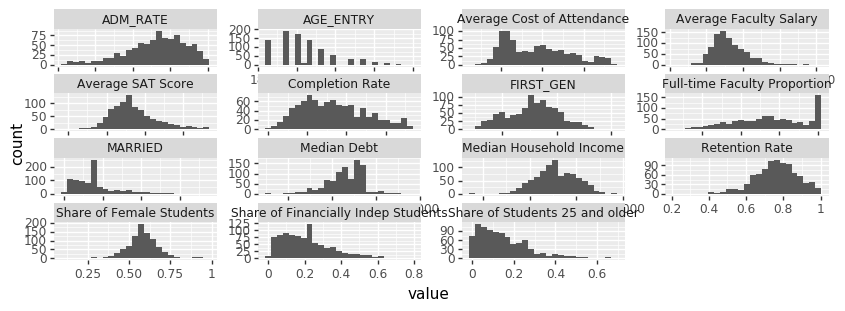

<ggplot: (-9223371866676650436)>

In [54]:
# Plot the continuous Variables 
d = train_X.select_dtypes(include=["int64", "float64"]).melt()
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

View distribution of outcome.

Text(0.5, 1.0, 'Distribution of Outcome')

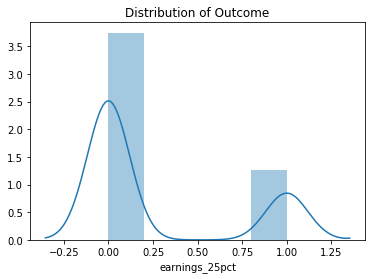

In [55]:
# Seaborn
ax = sns.distplot(train_y.earnings_25pct,hist=True,kde=True)
ax.set_title("Distribution of Outcome")

303 observations are coded as 1 and 906 as 0, therefore the classes are unbalanced. So, an accuracy of 75% can be achieved simply by predicting the complete set as majority label i.e. 0. But that is not helpful since we are building a classifier to classify the minority label from the majority label.

#### Standardize data

Standardization guidance obtained from:
- parametric_modeling_demo notebook by Professor Brodnax
- https://stackoverflow.com/questions/49444262/normalize-data-before-or-after-split-of-training-and-testing-data

Standardization is not required before running logistic regression, but standardization would be required since lasso is being used. As pointed out in the book <a href="https://web.stanford.edu/~hastie/Papers/ESLII.pdf">The Elements of Statistical Learning</a>, "The ridge solutions are not equivariant under scaling of the inputs, and so one normally standardizes the inputs before solving".






In [56]:
# standardize features to eliminate issues of scaling
scaler = StandardScaler()
                   
# standardize training data
std_train_X = pd.DataFrame(scaler.fit_transform(train_X), columns = X.columns)

# standardize test data
std_test_X = pd.DataFrame(scaler.fit_transform(test_X), columns = X.columns)

### 3 methods to address imbalanced classes will be tested below:###
1. Oversampling minority class
2. Undersampling majority class
3. Generating Synthetic Samples

Guidance obtained from:
- https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

#### <u> 1. Oversample Minority Class </u>

In [57]:
# append train_y to std_train_X
X = std_train_X.copy()
X['earnings_25pct'] = train_y.earnings_25pct.values

In [58]:
# separate minority and majority classes
not_top25 = X[X.earnings_25pct==0]
top25 = X[X.earnings_25pct==1]

# upsample minority
top25_upsampled = resample(top25,
                          replace=True, # sample with replacement
                          n_samples=len(not_top25), # match number in majority class
                          random_state=123) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_top25, top25_upsampled])

# check new class counts
upsampled.earnings_25pct.value_counts()

1.0    678
0.0    678
Name: earnings_25pct, dtype: int64

In [59]:
train_y = upsampled.earnings_25pct
train_X = upsampled.drop('earnings_25pct', axis=1)

Note: now use train_X where training data required, and std_test_X where test data required.

In [60]:
# hyperparameter
grid={"C":np.arange(0,1,0.1)}

# model
logreg=LogisticRegression(penalty = 'l1', solver = 'liblinear')

# GridSearch
logreg_cv=GridSearchCV(logreg,grid,cv=10)

In [61]:
# Run GridSearch
logreg_cv.fit(train_X,train_y)

GridSearchCV(cv=10,
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid={'C': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])})

In [62]:
logreg_cv.best_params_

{'C': 0.8}

Most appropriate value of alpha = 0.8

In [63]:
# store best estimator
logreg_cv_mod = logreg_cv.best_estimator_
logreg_cv_mod

LogisticRegression(C=0.8, penalty='l1', solver='liblinear')

#### Test Performance and Model Evaluation
Check how well the best performing model does on the test data that it wasn't trained on.

In [64]:
# Predict() method will use the best model out of the scan
pred_y = logreg_cv.predict(std_test_X)

In [65]:
# Look at evaluation metrics on the test data
print('Area Under Curve:',m.roc_auc_score(test_y,logreg_cv_mod.predict_proba(std_test_X)[:,1]))
print('Accuracy score:', m.accuracy_score(test_y,pred_y))
print("Precision:",metrics.precision_score(test_y, pred_y))
print('F1 score: ', f1_score(test_y, pred_y))
print('Recall score: ', recall_score(test_y, pred_y))

Area Under Curve: 0.8885964912280702
Accuracy score: 0.8118811881188119
Precision: 0.5833333333333334
F1 score:  0.6885245901639344
Recall score:  0.84


#### <u> 2. Undersample Majority Class </u>

In [66]:
y = df1[['earnings_25pct']]
X = df1.drop(columns=['earnings_25pct'])

# split data
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=123)

In [67]:
# standardize features to eliminate issues of scaling
scaler = StandardScaler()
                   
# standardize training data
std_train_X = pd.DataFrame(scaler.fit_transform(train_X), columns = X.columns)

# standardize test data
std_test_X = pd.DataFrame(scaler.fit_transform(test_X), columns = X.columns)

In [68]:
# append train_y to std_train_X
X = std_train_X.copy()
X['earnings_25pct'] = train_y.earnings_25pct.values

In [69]:
# separate minority and majority classes
not_top25 = X[X.earnings_25pct==0]
top25 = X[X.earnings_25pct==1]

# downsample majority
not_top25_downsampled = resample(not_top25,
                                replace = False, # sample without replacement
                                n_samples = len(top25), # match number in minority class
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_top25_downsampled, top25])

# checking counts
downsampled.earnings_25pct.value_counts()

1.0    228
0.0    228
Name: earnings_25pct, dtype: int64

There is now an equal ratio of top 25% earnings to "not top 25% earnings", but in this case there is a much smaller quantity of data to train the model on. Let’s again apply logistic lasso regression.

In [70]:
train_y = downsampled.earnings_25pct
train_X = downsampled.drop('earnings_25pct', axis=1)

Note: now use train_X where training data required, and std_test_X where test data required.

In [71]:
# hyperparameter
grid={"C":np.arange(0,1,0.1)}

# model
logreg=LogisticRegression(penalty = 'l1', solver = 'liblinear')

# GridSearch
logreg_cv=GridSearchCV(logreg,grid,cv=10)

In [72]:
# Run GridSearch
logreg_cv.fit(train_X,train_y)

GridSearchCV(cv=10,
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid={'C': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])})

In [73]:
logreg_cv.best_params_

{'C': 0.9}

Most appropriate value of alpha = 0.9

In [74]:
# store best estimator
logreg_cv_mod = logreg_cv.best_estimator_
logreg_cv_mod

LogisticRegression(C=0.9, penalty='l1', solver='liblinear')

#### Test Performance and Model Evaluation
Check how well the best performing model does on the test data that it wasn't trained on.

In [75]:
# Predict() method will use the best model out of the scan
pred_y = logreg_cv.predict(std_test_X)

In [76]:
# Look at evaluation metrics on the test data
print('Area Under Curve:',m.roc_auc_score(test_y,logreg_cv_mod.predict_proba(std_test_X)[:,1]))
print('Accuracy score:', m.accuracy_score(test_y,pred_y))
print("Precision:",metrics.precision_score(test_y, pred_y))
print('F1 score: ', f1_score(test_y, pred_y))
print('Recall score: ', recall_score(test_y, pred_y))

Area Under Curve: 0.8794736842105264
Accuracy score: 0.801980198019802
Precision: 0.5742574257425742
F1 score:  0.6590909090909091
Recall score:  0.7733333333333333


Precision, AUC, Accuracy, F1 score, and Recall score all decreased compared to oversampling.

#### <u>3. Generating Synthetic Samples</u>

A technique similar to upsampling is to create synthetic samples. I will use imblearn’s SMOTE or Synthetic Minority Oversampling Technique. SMOTE uses a nearest neighbors algorithm to generate new and synthetic data we can use for training our model.

In [77]:
y = df1[['earnings_25pct']]
X = df1.drop(columns=['earnings_25pct'])

# split data
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=123)

#### Standardize data

In [78]:
# standardize features to eliminate issues of scaling
scaler = StandardScaler()
                   
# standardize training data
std_train_X = pd.DataFrame(scaler.fit_transform(train_X), columns = X.columns)

# standardize test data
std_test_X = pd.DataFrame(scaler.fit_transform(test_X), columns = X.columns)

In [79]:
sm = SMOTE(random_state=123)

X_train, y_train = sm.fit_sample(std_train_X, train_y)

Note: now use X_train where training data required, and std_test_X where test data required.

In [80]:
# hyperparameter
grid={"C":np.arange(0,1,0.1)}

# model
logreg=LogisticRegression(penalty = 'l1', solver = 'liblinear')

# GridSearch
logreg_cv=GridSearchCV(logreg,grid,cv=10)

In [81]:
# Run GridSearch
logreg_cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid={'C': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])})

In [82]:
logreg_cv.best_params_

{'C': 0.30000000000000004}

Most appropriate value of alpha =  0.30000000000000004

In [83]:
# store best estimator
logreg_cv_mod = logreg_cv.best_estimator_
logreg_cv_mod

LogisticRegression(C=0.30000000000000004, penalty='l1', solver='liblinear')

#### Test Performance and Model Evaluation
Check how well the best performing model does on the test data that it wasn't trained on.

In [84]:
# Predict() method will use the best model out of the scan
pred_y = logreg_cv.predict(std_test_X)

In [85]:
# Look at evaluation metrics on the test data
print('Area Under Curve:',m.roc_auc_score(test_y,logreg_cv_mod.predict_proba(std_test_X)[:,1]))
print('Accuracy score:', m.accuracy_score(test_y,pred_y))
print("Precision:",metrics.precision_score(test_y, pred_y))
print('F1 score: ', f1_score(test_y, pred_y))
print('Recall score: ', recall_score(test_y, pred_y))

Area Under Curve: 0.902748538011696
Accuracy score: 0.8217821782178217
Precision: 0.6039603960396039
F1 score:  0.6931818181818181
Recall score:  0.8133333333333334


Except for recall, all evaluation metrics are better as compared to oversampling. 

The Synthetic Minority Oversampling Technique (SMOTE) therefore seems to be the best technique to address imbalanced classes based on the evaluation metrics discussed. Therefore, the final model ahead will use SMOTE.

## <center> <font color="royalblue"> Parametric Model: Logistic Lasso Regression (Final)

#### Split dataset

In [86]:
y = df1[['earnings_25pct']]
X = df1.drop(columns=['earnings_25pct'])

# split data
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=123)

#### Standardize data
Standardization guidance obtained from: 

- parametric_modeling_demo notebook by Professor Brodnax
- https://stackoverflow.com/questions/49444262/normalize-data-before-or-after-split-of-training-and-testing-data

In [87]:
# standardize features to eliminate issues of scaling
scaler = StandardScaler()
                   
# standardize training data
std_train_X = pd.DataFrame(scaler.fit_transform(train_X), columns = X.columns)

# standardize test data
std_test_X = pd.DataFrame(scaler.fit_transform(test_X), columns = X.columns)

#### <u>Synthetic Minority Oversampling Technique</u>

A technique similar to upsampling is to create synthetic samples. I will use imblearn’s SMOTE or Synthetic Minority Oversampling Technique. SMOTE uses a nearest neighbors algorithm to generate new and synthetic data we can use for training our model.

In [88]:
sm = SMOTE(random_state=123)

X_train, y_train = sm.fit_sample(std_train_X, train_y)

Note: now use X_train where training data required, and std_test_X where test data required.

In [89]:
# hyperparameter
grid={"C":np.arange(0,1,0.1)}

# model
logreg=LogisticRegression(penalty = 'l1', solver = 'liblinear')

# GridSearch
logreg_cv=GridSearchCV(logreg,grid,cv=10)

In [90]:
# Run GridSearch
logreg_cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid={'C': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])})

In [91]:
logreg_cv.best_params_

{'C': 0.30000000000000004}

Most appropriate value of alpha =  0.30000000000000004

In [92]:
# store best estimator
logreg_cv_mod = logreg_cv.best_estimator_
logreg_cv_mod

LogisticRegression(C=0.30000000000000004, penalty='l1', solver='liblinear')

#### Test Performance and Model Evaluation
Check how well the best performing model does on the test data that it wasn't trained on.

In [93]:
# Predict() method will use the best model out of the scan
pred_y = logreg_cv.predict(std_test_X)

In [94]:
# Look at evaluation metrics on the test data
print('Area Under Curve:',m.roc_auc_score(test_y,logreg_cv_mod.predict_proba(std_test_X)[:,1]))
print('Accuracy score:', m.accuracy_score(test_y,pred_y))
print("Precision:",metrics.precision_score(test_y, pred_y))
print('F1 score: ', f1_score(test_y, pred_y))
print('Recall score: ', recall_score(test_y, pred_y))

Area Under Curve: 0.9028070175438596
Accuracy score: 0.8217821782178217
Precision: 0.6039603960396039
F1 score:  0.6931818181818181
Recall score:  0.8133333333333334


In [95]:
# check overfitting - check performance of training data
# accuracy
print(m.accuracy_score(y_train,logreg_cv_mod.predict(X_train)))

0.8783185840707964


#### Confusion Matrix

#### <center> <font color='darkblue'>Confusion Matrix for the Binary Case</font>

|  | <center> Negative (predicted) | <center> Positive (predicted) |
| ----- | ----- | --- | 
| <center> **Negative (actual)** | <center> True Negatives |  <center> False Positives |
| <center> **Positive (actual)** | <center> False Negatives |  <center> True Positives |

In [96]:
# create confusion matrix
cnf_matrix = metrics.confusion_matrix(test_y, pred_y)
cnf_matrix

array([[188,  40],
       [ 14,  61]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

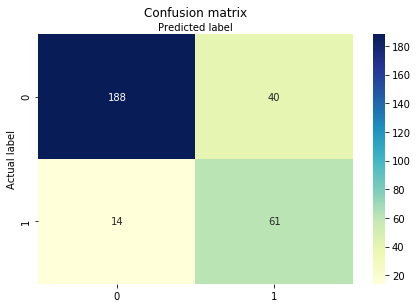

In [97]:
# visualize confusion matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

We can see that the most prevalent classification error is of **False Positives** i.e. when the actual value is negative but the model predicts a positive value. This is also known as **Type 1 error**. Other confusion matrix evaluation metrics have been calculated above.

#### Generate a ROC curve plot.

First, we need the model to return probabilities not predictions.

In [98]:
probs = logreg_cv_mod.predict_proba(std_test_X)
probs = pd.DataFrame(probs,columns=logreg_cv_mod.classes_)
#probs

In [99]:
# Generate the False Positive Rate and True Positive Rate Given different thresholds
fpr, tpr, thresholds = m.roc_curve(test_y, probs[1])

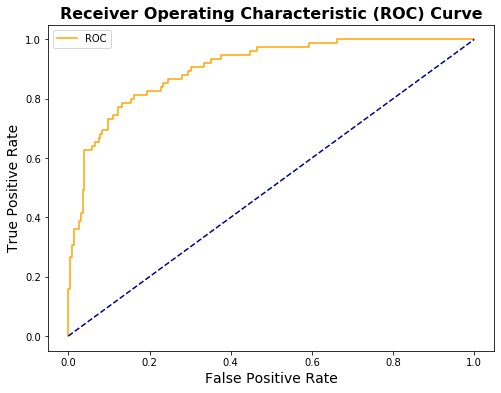

In [100]:
# plot ROC curve
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(8,6)
plt.show()

In [101]:
# Calculate area under ROC curve
print('Area Under Curve:',m.roc_auc_score(test_y,logreg_cv_mod.predict_proba(std_test_X)[:,1]))

Area Under Curve: 0.9028070175438596


### Determining Feature Importance

#### Feature Importance with `eli5`

Initialize the PermutationImportance class object.

In [102]:
perm_train = PermutationImportance(logreg_cv_mod,
                                   n_iter=5,random_state=123)

Fit it using the train (or test!) data

In [103]:
perm_train.fit(X_train,y_train)

PermutationImportance(estimator=LogisticRegression(C=0.30000000000000004,
                                                   penalty='l1',
                                                   solver='liblinear'),
                      random_state=123)

In [104]:
vi2 = eli5.explain_weights_df(perm_train,feature_names = list(X_train))

# view first 5 rows
vi2.head(5)

,feature,weight,std
0,Average Faculty Salary,0.169912,0.005248
1,Median Household Income,0.044985,0.004936
2,Share of Students 25 and older,0.026254,0.004028
3,CONTROL_Public,0.015487,0.002512
4,Completion Rate,0.014454,0.003891


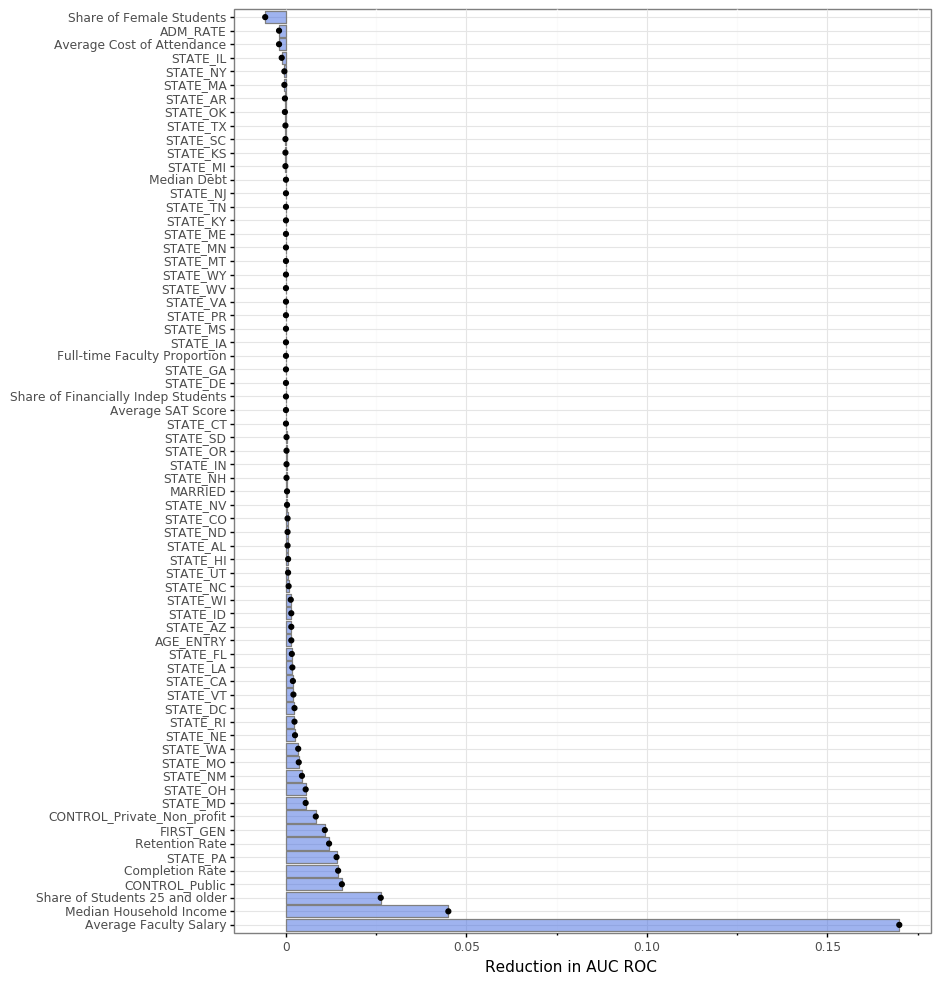

<ggplot: (-9223371866675729580)>

In [105]:
# Plot
plot_vi2_ = (
    ggplot(vi2,
          aes(x="feature",y="weight")) +
    geom_col(alpha=.5,fill="royalblue", color="gray") +
    geom_point() +
    theme_bw() + 
    scale_x_discrete(limits=vi2.feature.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")+
    theme(figure_size=(9, 12))
)

# save plot
plot_vi2_.save("plot_vi2.png", dpi =300)

# view plot
plot_vi2_

Most important feature is average faculty salary, followed by median household income,  the percentage of undergraduates aged 25 and above, whether the institutions is public, and the completion rate.

In [106]:
# store top 5 most important variables in separate dataframe
vi2_top = vi2.loc[:4,:]

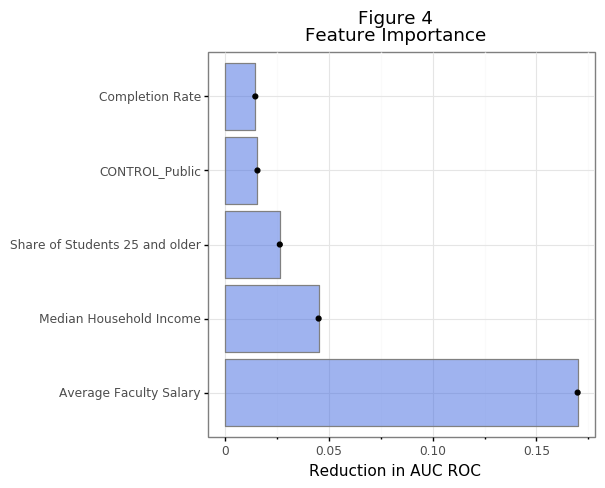

<ggplot: (-9223371866675956080)>

In [107]:
# Plot top 5 most important variables
plot_vi2_top5_lasso = (
    ggplot(vi2_top,
          aes(x="feature",y="weight")) +
    geom_col(alpha=.5,fill="royalblue", color="gray") +
    geom_point() +
    theme_bw() + 
    scale_x_discrete(limits=vi2_top.feature.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="",title="Figure 4\nFeature Importance")+
    theme(figure_size=(5, 5))
)

# save plot
plot_vi2_top5_lasso.save("plot_vi2_top5_lasso.png", dpi =300)

# view plot
plot_vi2_top5_lasso

#### Partial Dependency Plots

While feature importance shows what variables most affect predictions, partial dependence plots show how a feature affects predictions.

with `sklearn`

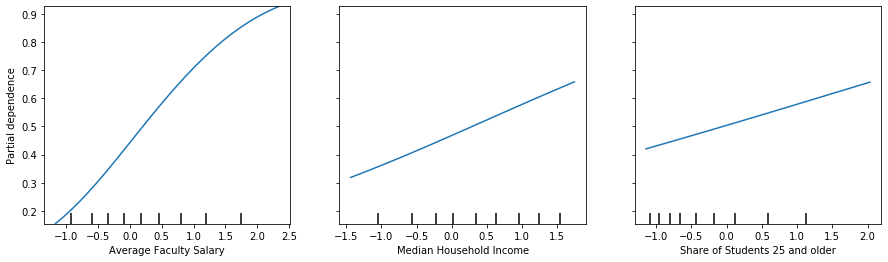

In [108]:
# Target specific features
features = ['Average Faculty Salary','Median Household Income','Share of Students 25 and older']

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(15, 4))
display = plot_partial_dependence(
    logreg_cv_mod, X_train, features,n_cols=5,
    n_jobs=4, grid_resolution=30,ax=ax
)

Since all variables were standardized, the x-axis includes negative values. These negative standardized values mean they are below the mean, whereas positive standardized values indicate that they are above the mean. Looking at the partial dependency plots, we can see that as average faculty increases, the probability of an educational institution's students' earnings being in the top 25% increases. The same can be said for median household income and the share of students 25 and older. 

#### Check Coefficients

We can also look at the coefficients of logistic lasso regression to determine the most important predictors. 

In [109]:
# separate target and predictors
y = df1[['earnings_25pct']]
X = df1.drop(columns=['earnings_25pct'])

In [110]:
# flatten 2-D array
logreg_coefs = logreg_cv_mod.coef_.flatten()

In [111]:
# view coefficients
df_llr_coefs = pd.DataFrame({'Variable': X.columns, 'Coef': logreg_coefs})
df_llr_coefs
df_llr_coefs = df_llr_coefs.sort_values('Coef', ascending = False)
df_llr_coefs = df_llr_coefs.reset_index(drop=True)

# view first 5 rows
df_llr_coefs.loc[:4,:]

,Variable,Coef
0,Average Faculty Salary,1.910445
1,Median Household Income,0.916900
2,Share of Students 25 and older,0.867496
3,Completion Rate,0.493231
4,Retention Rate,0.476437


The most influential predictors are the same as obtained through feature importance.

In [112]:
# count the number of coefficients being zeroed out
df_llr_coefs[df_llr_coefs == 0].count(axis=1).sum()

14

14 coefficients were zeroed out.

## <center> <font color="royalblue"> Non-Parametric Model: Decision Tree Classifier

Feature scaling (column standardization) not necessary to perform in decision trees. However, it helps with data visualization/manipulation and might be useful if you intend to compare performance with other data or other methods like SVM.
(https://towardsdatascience.com/decision-trees-d07e0f420175#:~:text=Feature%20scaling(column%20standardization)%20not,or%20other%20methods%20like%20SVM).

In this case, will not standardize data, especially since decision trees are less impacted by outliers.



### Hyperparameter Tuning

In [113]:
# separate target and features
y = df1[['earnings_25pct']]
X = df1.drop(columns=['earnings_25pct'])

# split data
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=123)

In [114]:
# parameters
param_dict = {
    "max_depth":range(1,10),
}

In [115]:
# model
decision_tree = DecisionTreeClassifier()

# Run GridSearch
dec_tree = GridSearchCV(decision_tree,
                   param_grid=param_dict,
                   cv=10)

In [116]:
# fit model
dec_tree.fit(train_X,train_y)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(1, 10)})

In [117]:
dec_tree.best_params_

{'max_depth': 3}

Most appropriate max depth = 3

In [118]:
# store best estimator
dtree_mod = dec_tree.best_estimator_
dtree_mod

DecisionTreeClassifier(max_depth=3)

#### Validation Curves

Can also select the optimal tree depth based on validation curves.

In [119]:
# define tree depths
depth_range = np.arange(1,11)

# validation curve
train_scores, test_scores = validation_curve(decision_tree, X, y, param_name='max_depth',
                                            param_range=depth_range, cv=5)

In [120]:
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

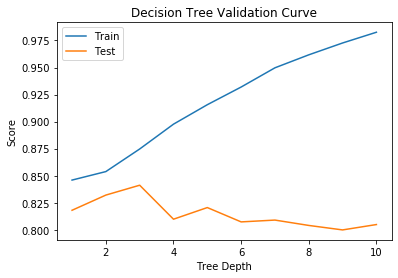

In [121]:
# plot validation curve
fig1 = plt.figure()
plt.plot(depth_range, train_mean, label='Train')
plt.plot(depth_range, test_mean, label='Test')
plt.xlabel('Tree Depth')
plt.ylabel('Score')
plt.title('Decision Tree Validation Curve')
plt.legend()
plt.show()

Test data is always going to have worse accuracy than the training data. We can see that selecting 3 as the maximum depth results in the best performance (least distance between training and test score/accuracy). 

### Test Performance and Model Evaluation
Check how well the best performing model does on the test data that it wasn't trained on.

In [122]:
# Predict() method will use the best model out of the scan
pred_y = dec_tree.predict(test_X)

In [123]:
# Look at evaluation metrics on the test data
print('Area Under Curve:',m.roc_auc_score(test_y,dtree_mod.predict_proba(test_X)[:,1]))
print('Accuracy score:', m.accuracy_score(test_y,pred_y))
print("Precision:",metrics.precision_score(test_y, pred_y))
print('F1 score: ', f1_score(test_y, pred_y))
print('Recall score: ', recall_score(test_y, pred_y))

Area Under Curve: 0.826140350877193
Accuracy score: 0.8382838283828383
Precision: 0.7241379310344828
F1 score:  0.6315789473684211
Recall score:  0.56


In [124]:
# check overfitting - check performance of training data
# accuracy
print(m.accuracy_score(train_y,dtree_mod.predict(train_X)))

0.8807947019867549


Decision trees are prone to overfitting. However, potential overfitting seems to have been addressed by setting an optimal maximum tree depth based on a grid search/validation curves. 

#### Confusion Matrix

#### <center> <font color='darkblue'>Confusion Matrix for the Binary Case</font>

|  | <center> Negative (predicted) | <center> Positive (predicted) |
| ----- | ----- | --- | 
| <center> **Negative (actual)** | <center> True Negatives |  <center> False Positives |
| <center> **Positive (actual)** | <center> False Negatives |  <center> True Positives |

In [125]:
# create confusion matrix
cnf_matrix = metrics.confusion_matrix(test_y, pred_y)
cnf_matrix

array([[212,  16],
       [ 33,  42]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

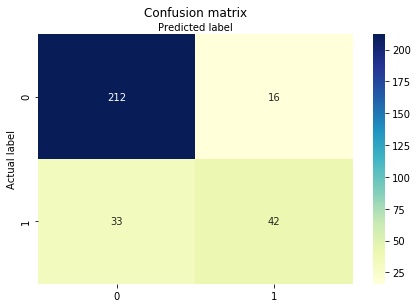

In [126]:
# visualize confusion matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

We can see that the most prevalent classification error is of **False Negative** i.e. when the actual value is positive but the model predicts a negative value. Other confusion matrix evaluation metrics have been calculated above.

#### Generate a ROC curve plot.

First, we need the model to return probabilities not predictions.

In [127]:
probs = dtree_mod.predict_proba(test_X)
probs = pd.DataFrame(probs,columns=dtree_mod.classes_)
#probs

In [128]:
# Generate the False Positive Rate and True Positive Rate Given different thresholds
fpr, tpr, thresholds = m.roc_curve(test_y, probs[1])

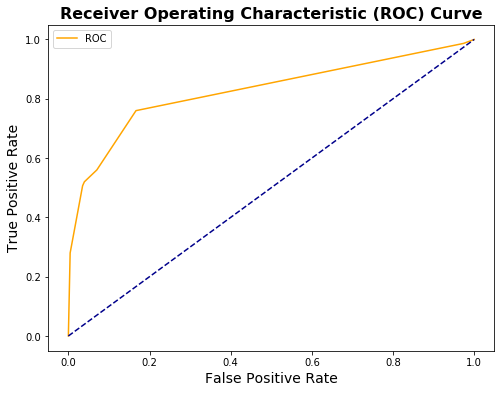

In [129]:
# plot ROC curve
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(8,6)
plt.show()

In [130]:
# Calculate area under ROC curve
print('Area Under Curve:',m.roc_auc_score(test_y,dtree_mod.predict_proba(test_X)[:,1]))

Area Under Curve: 0.826140350877193


### Determining Feature Importance

#### Feature Importance with `eli5`

Initialize the PermutationImportance class object.

In [131]:
perm_train = PermutationImportance(dtree_mod,
                                   n_iter=5,random_state=123)

Fit it using the train (or test!) data

In [132]:
perm_train.fit(train_X,train_y)

PermutationImportance(estimator=DecisionTreeClassifier(max_depth=3),
                      random_state=123)

In [133]:
vi2 = eli5.explain_weights_df(perm_train,feature_names = list(train_X))

# view vi2
#vi2

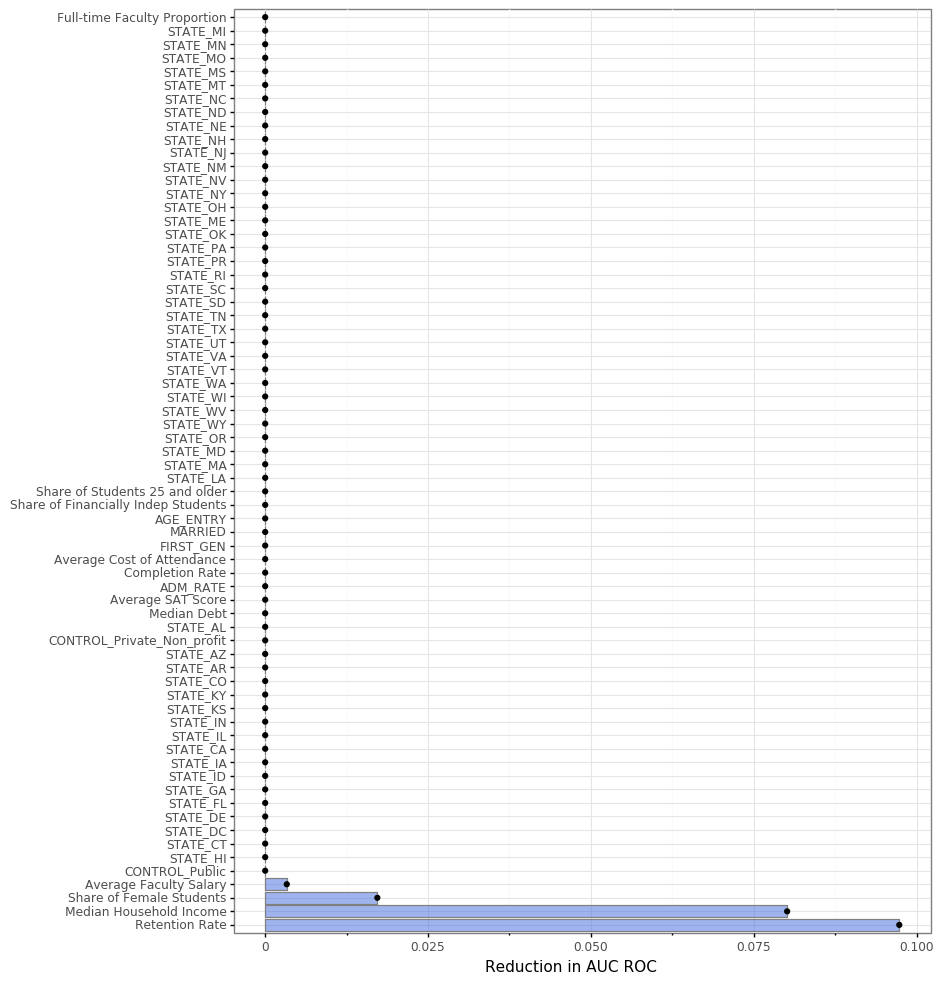

<ggplot: (-9223371866675459820)>

In [134]:
# Plot
plot_vi2_dt = (
    ggplot(vi2,
          aes(x="feature",y="weight")) +
    geom_col(alpha=.5,fill="royalblue", color="gray") +
    geom_point() +
    theme_bw() + 
    scale_x_discrete(limits=vi2.feature.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")+
    theme(figure_size=(9, 12))
)

# save plot
plot_vi2_dt.save("plot_vi2_dt.png", dpi =300)

# view plot
plot_vi2_dt

The most important features are full-time student retention rate at four-year institutions, median household income, share of female students and the average faculty salary. 

In [135]:
# store most important variables in separate dataframe
vi2_top = vi2.loc[:3,:]

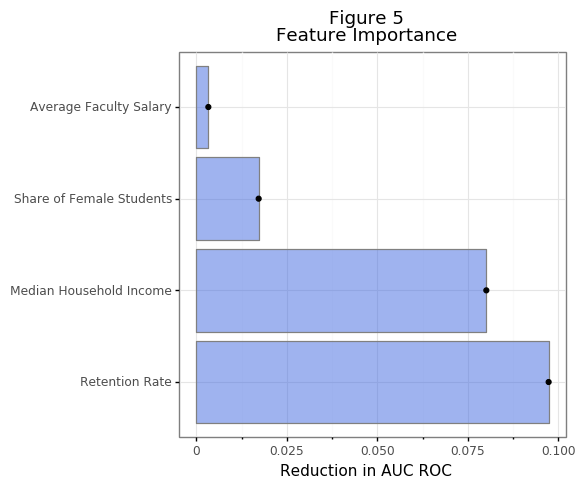

<ggplot: (-9223371866675496712)>

In [136]:
# Plot
plot_vi2_top4_dt = (
    ggplot(vi2_top,
          aes(x="feature",y="weight")) +
    geom_col(alpha=.5,fill="royalblue", color="gray") +
    geom_point() +
    theme_bw() + 
    scale_x_discrete(limits=vi2_top.feature.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="",title="Figure 5\nFeature Importance")+
    theme(figure_size=(5, 5))
)

# save plot
plot_vi2_top4_dt.save("plot_vi2_top4_dt.png", dpi =300)

# view plot
plot_vi2_top4_dt

#### Partial Dependency Plots

While feature importance shows what variables most affect predictions, partial dependence plots show how a feature affects predictions.

with `sklearn`

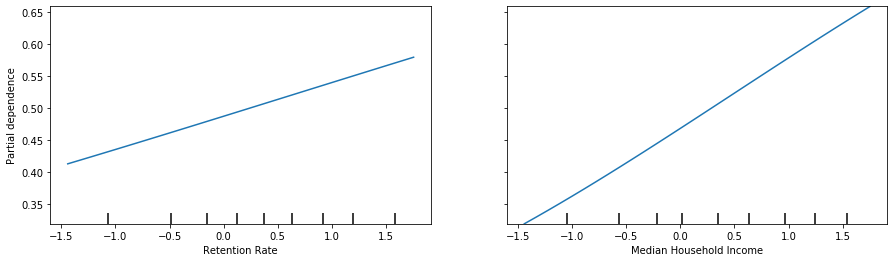

In [137]:
# Target specific features
features = ['Retention Rate','Median Household Income']

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(15, 4))
display = plot_partial_dependence(
    logreg_cv_mod, X_train, features,n_cols=5,
    n_jobs=4, grid_resolution=30,ax=ax
)

Since all variables were standardized, the x-axis includes negative values. These negative standardized values mean they are below the mean, whereas positive standardized values indicate that they are above the mean. Looking at the partial dependency plots, we can see that as median household income increases, the probability of an educational institution's students' earnings being in the top 25% increases. The same can be said for the retention rate, though the relationship is not as strong.

In [138]:
# view the target
list(set(test_y.earnings_25pct))

[0.0, 1.0]

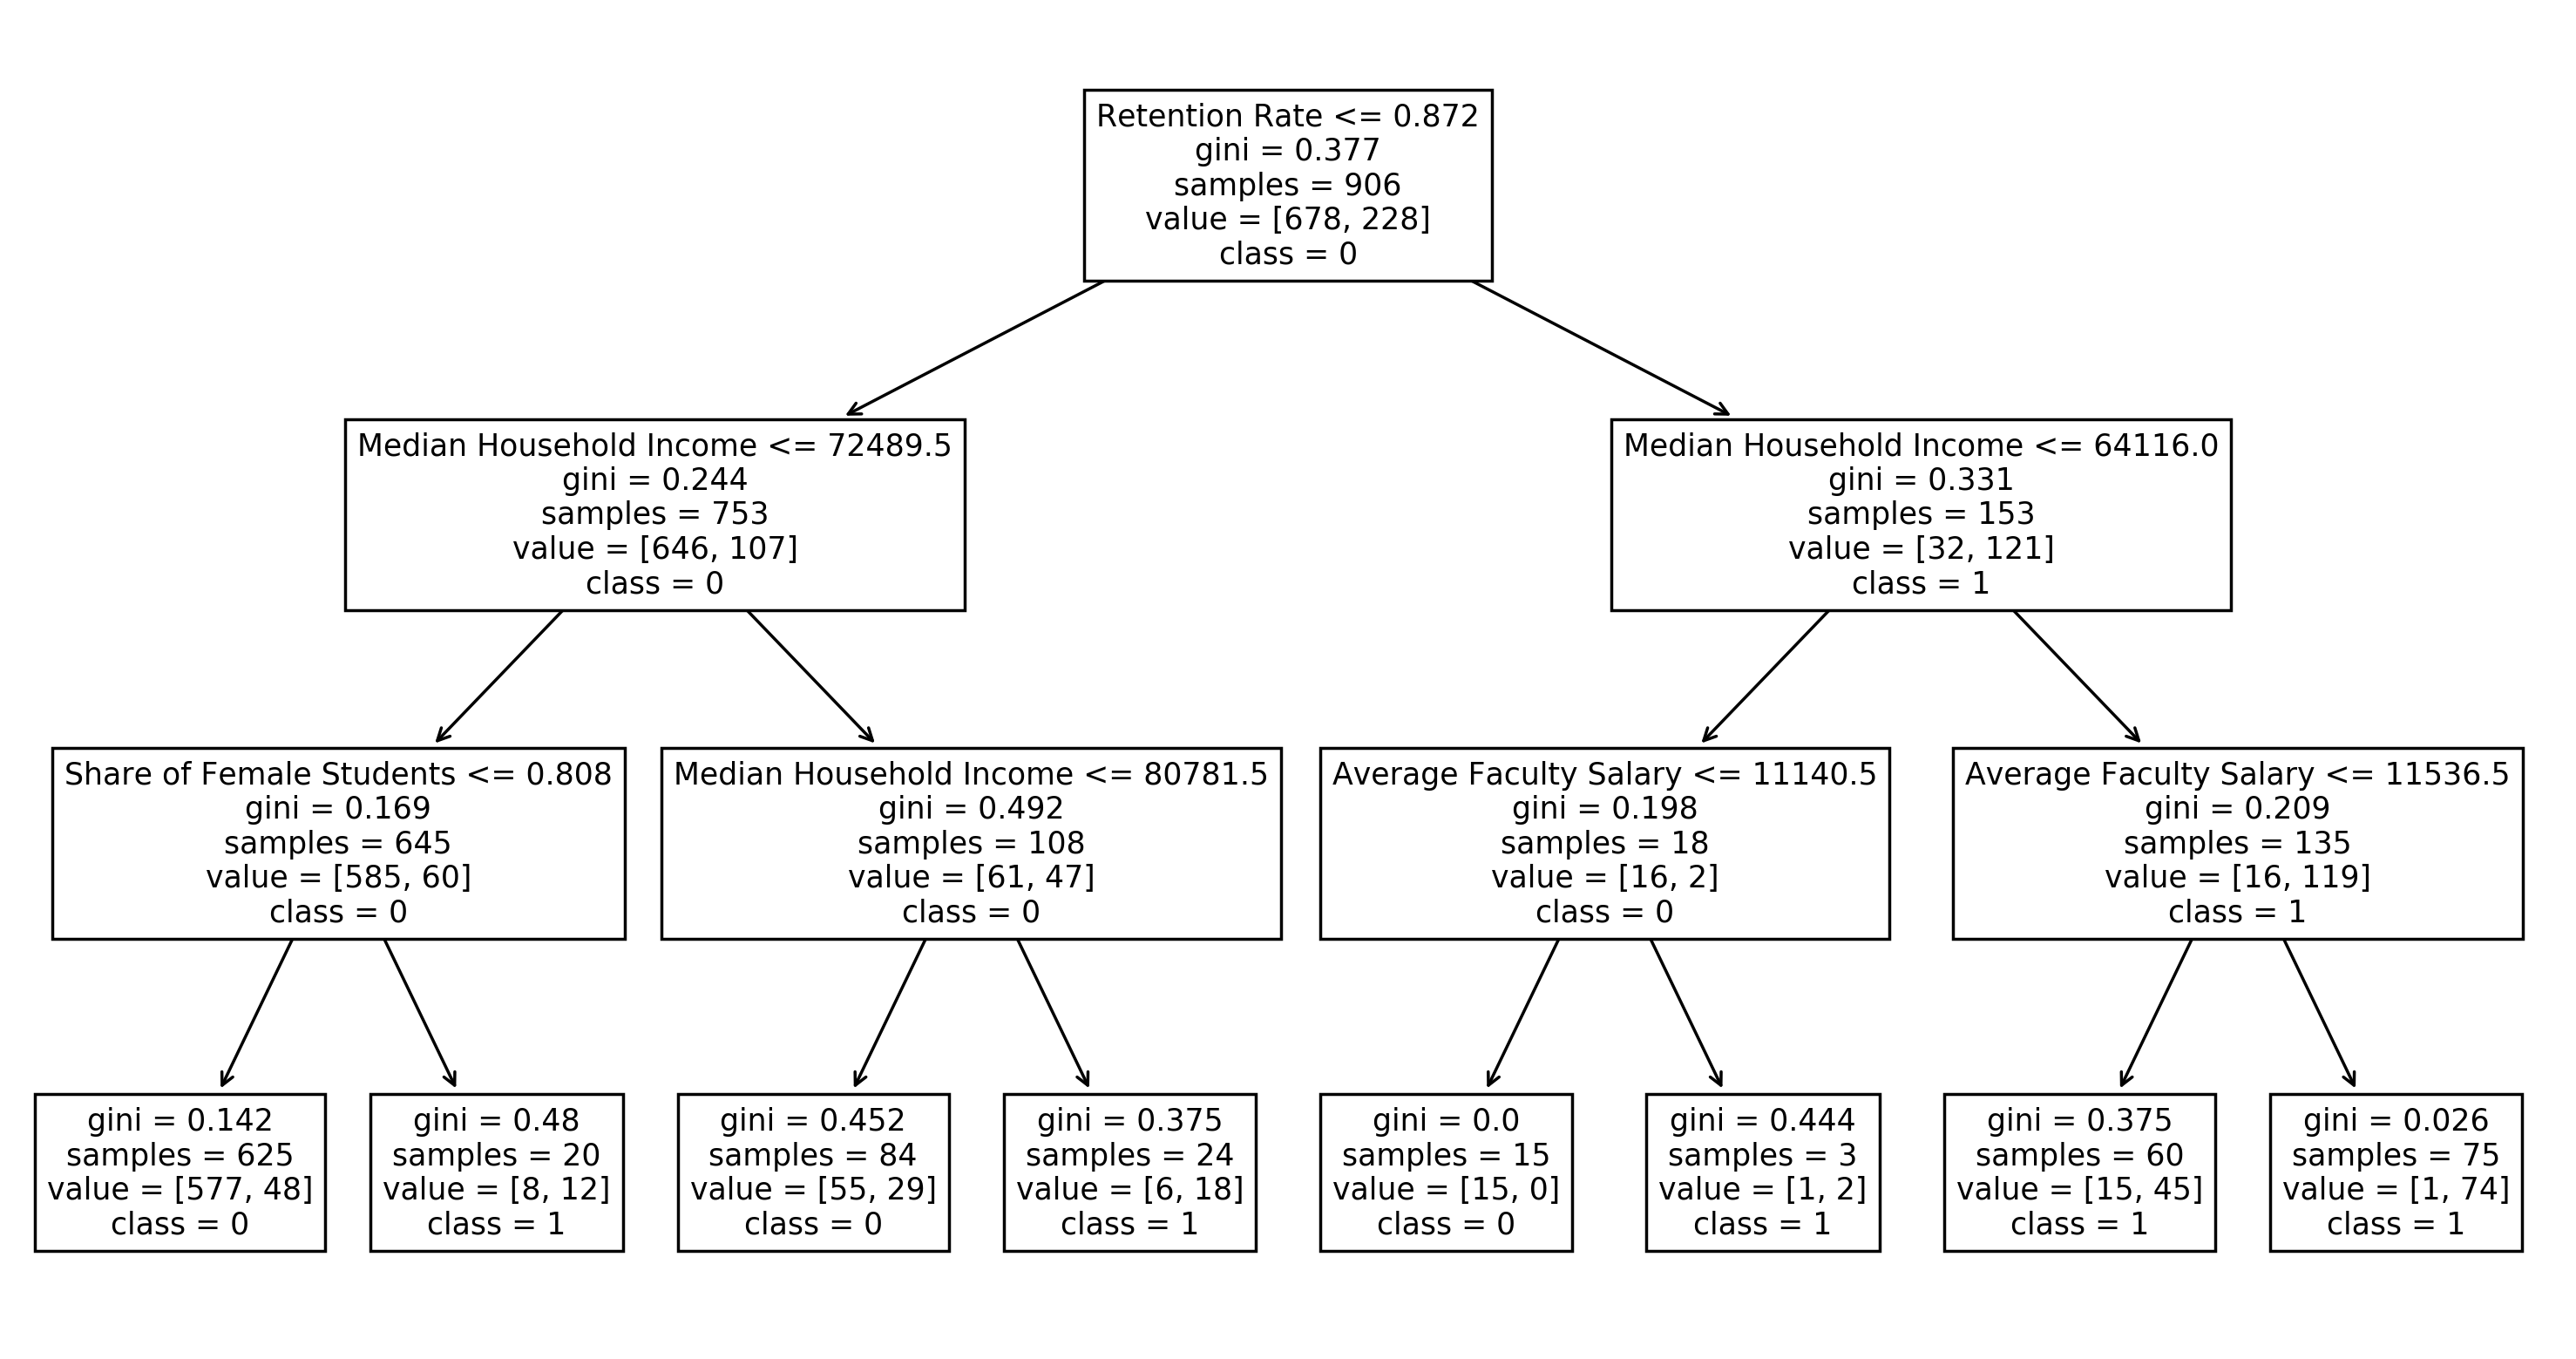

In [139]:
# store target values as str to use to visualize classes in tree
names = ['0','1']

# visualize tree
plt.figure(figsize=(15, 8),dpi=250)
plot_tree(dtree_mod, feature_names = train_X.columns, 
          class_names = names, fontsize = 10)
plt.show()

If retention rate is less than or equal to 87%, median household income is less than or equal to 72,490 dollars, and the share of female students is greater than 81%, student earnings are predicted to be in the top quartile.

If retention rate is greater than 87%, median household income is less than or equal to 64,116 dollars, and the average faculty salary is greater than 11,141 dollars, student earnings are predicted to be in the top quartile.

If retention rate is less than or equal to 87%, median household income is more than 72,490 dollars, and the median household income is greater than 80,782 dollars, student earnings are likely to be in the top quartile.

## <center> <font color="royalblue"> Additional: Further Analysis

Since different types of colleges e.g. private and public may differ substantially such as in terms of cost of attendance, the research question can potentially be answered separately for each college type in addition to making an overall analysis and answering this question collectively for all types of colleges as done above.

### <center> <font color="royalblue"> Private Non-profit Educational Institutions

In [140]:
# create copy
df2 = df_orig.copy()

In [141]:
# drop duplicates of OPEID6, keeping only the first instance. 
df2.drop_duplicates(subset ="OPEID6",
                     keep = "first", inplace = True)
# check shape 
df2.shape

(5183, 21)

In [142]:
# check for missing values
#df2.isnull().sum()

Keep only **4-year private non-profit institutions** 

In [143]:
# keep only those rows that correspond to private, 4-year institutions 
df2 = df2[(df2.ICLEVEL == 1) & (df2.CONTROL == 2)]

# check new shape of data
df2.shape

(1520, 21)

In [144]:
# remove rows where SAT_AVG is not available (the var with the max missingness)
df2 = df2[df2['SAT_AVG'].notna()]

# check shape of data
df2.shape

(756, 21)

In [145]:
# check for missingness again
df2.isnull().sum()

STATE                 0
CONTROL               0
PFTFAC                7
AVGFACSAL             3
ICLEVEL               0
OPEID6                0
UG25ABV               3
DEP_STAT_PCT_IND     68
DEPENDENT            68
FEMALE               33
RET_FT4_POOLED        5
AGE_ENTRY             6
MARRIED             229
FIRST_GEN            47
MEDIAN_HH_INC        18
COSTT4_A              6
C100_4_POOLED         8
ADM_RATE              0
SAT_AVG               0
GRAD_DEBT_MDN        17
MD_EARN_WNE_P10      27
dtype: int64

In [146]:
# fill missing values with mean column values (since categorical vars have no missingness, this does not affect them)
df2.fillna(df2.mean(), inplace=True)

In [147]:
# check missingness again
#df2.isnull().sum()

Convert the following variables to categorical variables:
- `OPEID6`
- `ICLEVEL`
- `STATE`  

*Note: None of these categorical variables contain missing values.*

The first 2 variables will be changed to Categorical variable types but no dummies would be created since `ICLEVEL` has only one value while `OPEID6` has as many unique values as there are rows. 

Dummies would be created for `STATE` since both these variables will be used as predictors in the machine learning models. 

In [148]:
# Convert into categorical variables
df2['OPEID6'] = pd.Categorical(df2['OPEID6'])
df2['ICLEVEL'] = pd.Categorical(df2['ICLEVEL'])

In [149]:
# convert state variable to dummy variable
df2 = pd.get_dummies(df2, columns=['STATE'], drop_first=True)

# check df
df2.head(2)

,CONTROL,PFTFAC,AVGFACSAL,ICLEVEL,OPEID6,UG25ABV,DEP_STAT_PCT_IND,DEPENDENT,FEMALE,RET_FT4_POOLED,...,STATE_SC,STATE_SD,STATE_TN,STATE_TX,STATE_UT,STATE_VA,STATE_VT,STATE_WA,STATE_WI,STATE_WV
10,2,0.6667,7688.0,1,001012,0.0133,0.031674,0.968326,0.520362,0.7994,...,0,0,0,0,0,0,0,0,0,0
15,2,0.4534,5743.0,1,001003,0.4188,0.611552,0.388448,0.638732,0.5434,...,0,0,0,0,0,0,0,0,0,0


In [150]:
# look at correlation
corr = df2.corr(method='pearson')
corr = corr.unstack()
corr[(corr >= 0.7) & (corr != 1.000000)]

AVGFACSAL         COSTT4_A            0.761536
                  SAT_AVG             0.787051
                  MD_EARN_WNE_P10     0.753777
UG25ABV           DEP_STAT_PCT_IND    0.860906
                  AGE_ENTRY           0.879209
DEP_STAT_PCT_IND  UG25ABV             0.860906
                  AGE_ENTRY           0.936362
                  MARRIED             0.755706
RET_FT4_POOLED    C100_4_POOLED       0.720849
                  SAT_AVG             0.771789
AGE_ENTRY         UG25ABV             0.879209
                  DEP_STAT_PCT_IND    0.936362
                  MARRIED             0.721899
MARRIED           DEP_STAT_PCT_IND    0.755706
                  AGE_ENTRY           0.721899
COSTT4_A          AVGFACSAL           0.761536
                  C100_4_POOLED       0.752842
                  SAT_AVG             0.762383
C100_4_POOLED     RET_FT4_POOLED      0.720849
                  COSTT4_A            0.752842
                  SAT_AVG             0.785277
SAT_AVG      

`AGE_ENTRY`, and `DEP_STAT_PCT_IND` and `UG25ABV` are highly correlated. Moreover, the share of students who are married (`MARRIED`) is correlated with the share of students who are financially independent (`DEP_STAT_PCT_IND`) as well as the average age of entry. The retention and completion rates are highly correlated with average SAT scores. There is also high correlation between the completion rate and the average cost of the program.

In [151]:
### Detecting multicollinearity

# the independent variables set
X = df2[['ADM_RATE', 'SAT_AVG', 'COSTT4_A', 'AVGFACSAL', 'PFTFAC', 'UG25ABV',
         'DEP_STAT_PCT_IND', 'GRAD_DEBT_MDN', 'AGE_ENTRY', 'FEMALE', 'MARRIED', 'DEPENDENT',
         'FIRST_GEN', 'MEDIAN_HH_INC', 'MD_EARN_WNE_P10', 'RET_FT4_POOLED', 
         'C100_4_POOLED']] # all variables excluding OPEID6, STATE, ICLEVEL and CONTROL

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

             feature         VIF
0           ADM_RATE    1.581051
1            SAT_AVG    7.822175
2           COSTT4_A    4.573034
3          AVGFACSAL    5.070615
4             PFTFAC    1.182734
5            UG25ABV    5.609739
6   DEP_STAT_PCT_IND  185.134859
7      GRAD_DEBT_MDN    1.574478
8          AGE_ENTRY   10.728657
9             FEMALE    1.460590
10           MARRIED    2.807233
11         DEPENDENT  825.437923
12         FIRST_GEN    3.325964
13     MEDIAN_HH_INC    2.247865
14   MD_EARN_WNE_P10    2.552180
15    RET_FT4_POOLED    3.361047
16     C100_4_POOLED    3.773198


The percentage of students who are financially independent (`DEP_STAT_PCT_IND`) and the share of dependent students (`DEPENDENT`) have extremely high VIF values. This is expected as the more dependent students there are, the less the percentage of financially independent students would be. Hence, considering these two features together leads to a model with high multicollinearity. In order to bring down the multicollinearity between the correlated features, one of the correlated features (`DEPENDENT`) will be dropped.  

In [152]:
# drop DEPENDENT
df2 = df2.drop(columns = 'DEPENDENT')

In [153]:
### Detect multicollinearity again

# the independent variables set
X = df2[['ADM_RATE', 'SAT_AVG', 'COSTT4_A', 'AVGFACSAL', 'PFTFAC', 'UG25ABV',
         'DEP_STAT_PCT_IND', 'GRAD_DEBT_MDN', 'AGE_ENTRY', 'FEMALE', 'MARRIED',
         'FIRST_GEN', 'MEDIAN_HH_INC', 'MD_EARN_WNE_P10', 'RET_FT4_POOLED', 
         'C100_4_POOLED']] # all variables excluding OPEID6, STATE, ICLEVEL and CONTROL + removed var

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

             feature         VIF
0           ADM_RATE   15.283501
1            SAT_AVG  358.484187
2           COSTT4_A   62.276081
3          AVGFACSAL   46.757703
4             PFTFAC    8.671110
5            UG25ABV   11.371233
6   DEP_STAT_PCT_IND   22.743752
7      GRAD_DEBT_MDN   57.274631
8          AGE_ENTRY  423.262624
9             FEMALE   36.684460
10           MARRIED    8.788890
11         FIRST_GEN   28.693345
12     MEDIAN_HH_INC   95.408927
13   MD_EARN_WNE_P10   36.997451
14    RET_FT4_POOLED  129.917825
15     C100_4_POOLED   25.852205


All variables have very high VIF values. This can lead to skewed or misleading results in a regression context, and therefore would be kept in mind while deciding which statistical models to use. 

In [154]:
# new shape
df2.shape

(756, 67)

# <center> <font color="royalblue"> Numerical Summaries  </font>

In [155]:
# create dataframe with quantitative variables (excluding dummy variables)
df_num = df2[['ADM_RATE', 'SAT_AVG', 'COSTT4_A', 'AVGFACSAL',
       'PFTFAC', 'UG25ABV', 'DEP_STAT_PCT_IND', 'GRAD_DEBT_MDN', 'AGE_ENTRY',
       'FEMALE', 'MARRIED', 'FIRST_GEN', 'MEDIAN_HH_INC',
       'MD_EARN_WNE_P10', 'RET_FT4_POOLED', 'C100_4_POOLED']]

df_num.shape

(756, 16)

In [156]:
# print descriptive statistics - round off to 2 decimal places
df_num1 = round(df_num.describe(include=['number']),2)
df_num1

,ADM_RATE,SAT_AVG,COSTT4_A,AVGFACSAL,PFTFAC,UG25ABV,DEP_STAT_PCT_IND,GRAD_DEBT_MDN,AGE_ENTRY,FEMALE,MARRIED,FIRST_GEN,MEDIAN_HH_INC,MD_EARN_WNE_P10,RET_FT4_POOLED,C100_4_POOLED
count,756.00,756.00,756.00,756.00,756.00,756.00,756.00,756.00,756.00,756.00,756.00,756.00,756.00,756.00,756.00,756.00
mean,0.63,1153.93,46266.30,7904.86,0.67,0.14,0.21,24023.77,21.62,0.58,0.09,0.29,66075.67,46621.95,0.76,0.48
std,0.21,133.68,12973.39,2715.58,0.27,0.14,0.16,3863.24,2.60,0.12,0.06,0.09,10031.63,12682.01,0.12,0.20
min,0.04,809.00,12223.00,1027.00,0.04,0.00,0.01,4833.00,19.00,0.15,0.01,0.09,31403.00,21100.00,0.11,0.00
25%,0.52,1067.75,37616.00,6223.00,0.45,0.03,0.09,22500.00,20.00,0.52,0.05,0.22,59011.50,38900.00,0.69,0.34
50%,0.66,1129.00,44894.50,7301.00,0.67,0.10,0.20,25000.00,21.00,0.58,0.09,0.29,65464.00,44400.00,0.78,0.47
75%,0.78,1212.00,54729.25,8888.00,0.97,0.21,0.29,26929.00,23.00,0.65,0.10,0.36,73333.50,50900.00,0.85,0.62
max,1.00,1566.00,75735.00,20484.00,1.00,0.68,0.80,35169.00,33.00,0.98,0.47,0.53,96737.00,124700.00,1.00,0.91


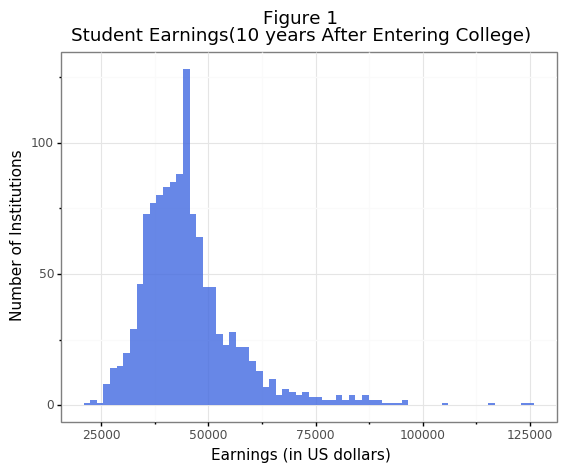

<ggplot: (-9223371866676034300)>

In [157]:
# check distribution of outcome variable

# plot
plot_outcome__ = (ggplot(df, aes(x = 'MD_EARN_WNE_P10')) +
  geom_histogram(fill="royalblue",alpha=0.8, bins=68) +
                scale_x_continuous() +
 labs(title="Figure 1\nStudent Earnings(10 years After Entering College)", x="Earnings (in US dollars)",y="Number of Institutions") +
 theme(figure_size=(10, 6))+
 theme_bw())


# view plot
plot_outcome__

Create binary outcome variable such that top 25% earnings are coded as 1:
- 1 if `MD_EARN_WNE_P10` >= 50,900 
- 0 if `MD_EARN_WNE_P10` < 50,900

In [158]:
# create copy of df
df3 = df2.copy()

# create a list of conditions
conditions = [
    (df3['MD_EARN_WNE_P10'] >= 50900),
    (df3['MD_EARN_WNE_P10'] < 50900)
    ]

# create a list of the to assign to each condition
values = ['1', '0']

# create a new column and use np.select to assign values to it using the lists as arguments
df3['earnings_25pct'] = np.select(conditions, values)

# display updated DataFrame
df3.head(3)

,CONTROL,PFTFAC,AVGFACSAL,ICLEVEL,OPEID6,UG25ABV,DEP_STAT_PCT_IND,FEMALE,RET_FT4_POOLED,AGE_ENTRY,...,STATE_SD,STATE_TN,STATE_TX,STATE_UT,STATE_VA,STATE_VT,STATE_WA,STATE_WI,STATE_WV,earnings_25pct
10,2,0.6667,7688.0,1,001012,0.0133,0.031674,0.520362,0.7994,19.0,...,0,0,0,0,0,0,0,0,0,0
15,2,0.4534,5743.0,1,001003,0.4188,0.611552,0.638732,0.5434,28.0,...,0,0,0,0,0,0,0,0,0,0
22,2,0.5714,6810.0,1,001019,0.1833,0.221893,0.470414,0.6701,23.0,...,0,0,0,0,0,0,0,0,0,0


Check the balance of classes.

In [159]:
# check balance
earnings_25pct_tab = pd.crosstab(index=df3["earnings_25pct"],  # Make a crosstab
                              columns="count")      # Name the count column

earnings_25pct_tab

col_0,count
earnings_25pct,
0,566
1,190


566 observations are coded as 0 and 190 as 1, therefore the classes are unbalanced.

In [160]:
# reset index
df3 = df3.reset_index(drop=True)

# view df3
df3.head(3)

,CONTROL,PFTFAC,AVGFACSAL,ICLEVEL,OPEID6,UG25ABV,DEP_STAT_PCT_IND,FEMALE,RET_FT4_POOLED,AGE_ENTRY,...,STATE_SD,STATE_TN,STATE_TX,STATE_UT,STATE_VA,STATE_VT,STATE_WA,STATE_WI,STATE_WV,earnings_25pct
0,2,0.6667,7688.0,1,001012,0.0133,0.031674,0.520362,0.7994,19.0,...,0,0,0,0,0,0,0,0,0,0
1,2,0.4534,5743.0,1,001003,0.4188,0.611552,0.638732,0.5434,28.0,...,0,0,0,0,0,0,0,0,0,0
2,2,0.5714,6810.0,1,001019,0.1833,0.221893,0.470414,0.6701,23.0,...,0,0,0,0,0,0,0,0,0,0


In [161]:
# check data types
#list(df3.dtypes)

In [162]:
# convert data type of outcome variable
convert_dict = {'earnings_25pct': float}
  
df3 = df3.astype(convert_dict)
#list(df3.dtypes)

Remove `OPEID6`, `MD_EARN_WNE_P10`, `CONTROL` and `ICLEVEL`

In [163]:
df3.drop('OPEID6', inplace=True, axis=1)
df3.drop('MD_EARN_WNE_P10', inplace=True, axis=1)
df3.drop('ICLEVEL', inplace=True, axis=1)
df3.drop('CONTROL', inplace=True, axis=1)

In [164]:
# check shape 
df3.shape

(756, 64)

In [165]:
# view columns
df3.columns

Index(['PFTFAC', 'AVGFACSAL', 'UG25ABV', 'DEP_STAT_PCT_IND', 'FEMALE',
       'RET_FT4_POOLED', 'AGE_ENTRY', 'MARRIED', 'FIRST_GEN', 'MEDIAN_HH_INC',
       'COSTT4_A', 'C100_4_POOLED', 'ADM_RATE', 'SAT_AVG', 'GRAD_DEBT_MDN',
       'STATE_AR', 'STATE_AZ', 'STATE_CA', 'STATE_CO', 'STATE_CT', 'STATE_DC',
       'STATE_DE', 'STATE_FL', 'STATE_GA', 'STATE_HI', 'STATE_IA', 'STATE_ID',
       'STATE_IL', 'STATE_IN', 'STATE_KS', 'STATE_KY', 'STATE_LA', 'STATE_MA',
       'STATE_MD', 'STATE_ME', 'STATE_MI', 'STATE_MN', 'STATE_MO', 'STATE_MS',
       'STATE_MT', 'STATE_NC', 'STATE_ND', 'STATE_NE', 'STATE_NH', 'STATE_NJ',
       'STATE_NM', 'STATE_NV', 'STATE_NY', 'STATE_OH', 'STATE_OK', 'STATE_OR',
       'STATE_PA', 'STATE_RI', 'STATE_SC', 'STATE_SD', 'STATE_TN', 'STATE_TX',
       'STATE_UT', 'STATE_VA', 'STATE_VT', 'STATE_WA', 'STATE_WI', 'STATE_WV',
       'earnings_25pct'],
      dtype='object')

In [166]:
# rename variables
df3.rename(columns={'SAT_AVG': 'Average SAT Score'}, inplace=True)
df3.rename(columns={'AVGFACSAL': 'Average Faculty Salary'}, inplace=True)
df3.rename(columns={'FEMALE': 'Share of Female Students'}, inplace=True)
df3.rename(columns={'RET_FT4_POOLED': 'Retention Rate'}, inplace=True)
df3.rename(columns={'MEDIAN_HH_INC': 'Median Household Income'}, inplace=True)
df3.rename(columns={'UG25ABV': 'Share of Students 25 and older'}, inplace=True)
df3.rename(columns={'C100_4_POOLED': 'Completion Rate'}, inplace=True)
df3.rename(columns={'PFTFAC': 'Full-time Faculty Proportion'}, inplace=True)
df3.rename(columns={'DEP_STAT_PCT_IND': 'Share of Financially Indep Students'}, inplace=True)
df3.rename(columns={'GRAD_DEBT_MDN': 'Median Debt'}, inplace=True)
df3.rename(columns={'COSTT4_A': 'Average Cost of Attendance'}, inplace=True)

## <center> <font color="royalblue"> Parametric Model: Logistic Lasso Regression

**Logistic LASSO regression**

Logistic regression makes some tweaks on linear regression by forcing the outcome to fall within the 0 to 1 range, and rearranging it so that it has a linear form, while LASSO is a shrinkage method. It works by adding a penalty term to the log likelihood function and selects from a set of variables in the regression, resulting in a more relevant and interpretable set of predictors (Tibshirani, 1996). In addition to being able to identify the most important predictors, logistic LASSO regression would also deal with the multicollinearity in the dataset, by selecting one of the multicollinear predictors (if it is important in determining the outcome) and shrinking the other one to zero. Moreover, outliers in the data will have less of an effect on logistic regression as compared to linear regression, since the logistic regression decision boundary only takes the points closer to it into consideration (outliers may still have an effect on the decision boundary however). As far as the issue of unbalanced classes affecting predictions, corrections proposed by King and Zeng (2001) can possibly be applied.

#### Split dataset

In [167]:
y = df3[['earnings_25pct']]
X = df3.drop(columns=['earnings_25pct'])

# split data
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=123)

View distribution of continuous variables.

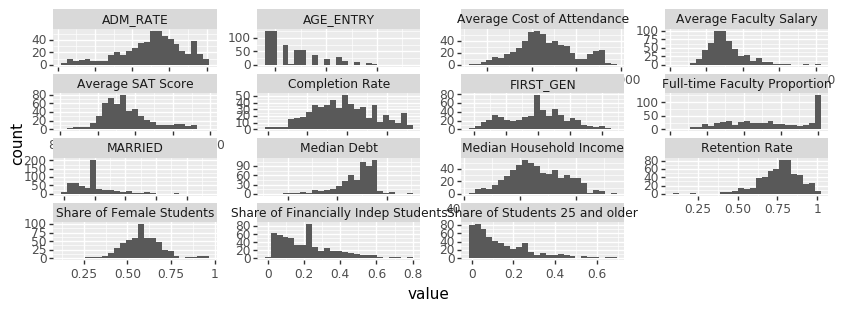

<ggplot: (-9223371866676823472)>

In [168]:
# Plot the continuous Variables 
d = train_X.select_dtypes(include=["int64", "float64"]).melt()
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

#### Standardize data

In [169]:
# standardize features to eliminate issues of scaling
scaler = StandardScaler()
                   
# standardize training data
std_train_X = pd.DataFrame(scaler.fit_transform(train_X), columns = X.columns)

# standardize test data
std_test_X = pd.DataFrame(scaler.fit_transform(test_X), columns = X.columns)

### 3 methods to address imbalanced classes will be tested below:###
1. Oversampling minority class
2. Undersampling majority class
3. Generating Synthetic Samples

#### <u> 1. Oversample Minority Class </u>

In [170]:
# append train_y to std_train_X
X = std_train_X.copy()
X['earnings_25pct'] = train_y.earnings_25pct.values

In [171]:
# separate minority and majority classes
not_top25 = X[X.earnings_25pct==0]
top25 = X[X.earnings_25pct==1]

# upsample minority
top25_upsampled = resample(top25,
                          replace=True, # sample with replacement
                          n_samples=len(not_top25), # match number in majority class
                          random_state=123) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_top25, top25_upsampled])

# check new class counts
upsampled.earnings_25pct.value_counts()

1.0    426
0.0    426
Name: earnings_25pct, dtype: int64

In [172]:
train_y = upsampled.earnings_25pct
train_X = upsampled.drop('earnings_25pct', axis=1)

Note: now use train_X where training data required, and std_test_X where test data required.

In [173]:
# hyperparameter
grid={"C":np.arange(0,1,0.1)}

# model
logreg=LogisticRegression(penalty = 'l1', solver = 'liblinear')

# GridSearch
logreg_cv=GridSearchCV(logreg,grid,cv=10)

In [174]:
# Run GridSearch
logreg_cv.fit(train_X,train_y)

GridSearchCV(cv=10,
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid={'C': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])})

In [175]:
logreg_cv.best_params_

{'C': 0.2}

Most appropriate value of alpha = 0.2

In [176]:
# store best estimator
logreg_cv_mod = logreg_cv.best_estimator_
logreg_cv_mod

LogisticRegression(C=0.2, penalty='l1', solver='liblinear')

#### Test Performance and Model Evaluation
Check how well the best performing model does on the test data that it wasn't trained on.

In [177]:
# Predict() method will use the best model out of the scan
pred_y = logreg_cv.predict(std_test_X)

In [178]:
# Look at evaluation metrics on the test data
print('Area Under Curve:',m.roc_auc_score(test_y,logreg_cv_mod.predict_proba(std_test_X)[:,1]))
print('Accuracy score:', m.accuracy_score(test_y,pred_y))
print("Precision:",metrics.precision_score(test_y, pred_y))
print('F1 score: ', f1_score(test_y, pred_y))
print('Recall score: ', recall_score(test_y, pred_y))

Area Under Curve: 0.9145772594752186
Accuracy score: 0.8412698412698413
Precision: 0.6792452830188679
F1 score:  0.7058823529411764
Recall score:  0.7346938775510204


#### <u> 2. Undersample Majority Class </u>

In [179]:
y = df3[['earnings_25pct']]
X = df3.drop(columns=['earnings_25pct'])

# split data
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=123)

In [180]:
# standardize features to eliminate issues of scaling
scaler = StandardScaler()
                   
# standardize training data
std_train_X = pd.DataFrame(scaler.fit_transform(train_X), columns = X.columns)

# standardize test data
std_test_X = pd.DataFrame(scaler.fit_transform(test_X), columns = X.columns)

In [181]:
# append train_y to std_train_X
X = std_train_X.copy()
X['earnings_25pct'] = train_y.earnings_25pct.values

In [182]:
# separate minority and majority classes
not_top25 = X[X.earnings_25pct==0]
top25 = X[X.earnings_25pct==1]

# downsample majority
not_top25_downsampled = resample(not_top25,
                                replace = False, # sample without replacement
                                n_samples = len(top25), # match number in minority class
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_top25_downsampled, top25])

# checking counts
downsampled.earnings_25pct.value_counts()

1.0    141
0.0    141
Name: earnings_25pct, dtype: int64

There is now an equal ratio of top 25% earnings to "not top 25% earnings", but in this case there is a much smaller quantity of data to train the model on. Let’s again apply logistic lasso regression.

In [183]:
train_y = downsampled.earnings_25pct
train_X = downsampled.drop('earnings_25pct', axis=1)

Note: now use train_X where training data required, and std_test_X where test data required.

In [184]:
# hyperparameter
grid={"C":np.arange(0,1,0.1)}

# model
logreg=LogisticRegression(penalty = 'l1', solver = 'liblinear')

# GridSearch
logreg_cv=GridSearchCV(logreg,grid,cv=10)

In [185]:
# Run GridSearch
logreg_cv.fit(train_X,train_y)

GridSearchCV(cv=10,
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid={'C': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])})

In [186]:
logreg_cv.best_params_

{'C': 0.1}

Most appropriate value of alpha = 0.1

In [187]:
# store best estimator
logreg_cv_mod = logreg_cv.best_estimator_
logreg_cv_mod

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

#### Test Performance and Model Evaluation
Check how well the best performing model does on the test data that it wasn't trained on.

In [188]:
# Predict() method will use the best model out of the scan
pred_y = logreg_cv.predict(std_test_X)

In [189]:
# Look at evaluation metrics on the test data
print('Area Under Curve:',m.roc_auc_score(test_y,logreg_cv_mod.predict_proba(std_test_X)[:,1]))
print('Accuracy score:', m.accuracy_score(test_y,pred_y))
print("Precision:",metrics.precision_score(test_y, pred_y))
print('F1 score: ', f1_score(test_y, pred_y))
print('Recall score: ', recall_score(test_y, pred_y))

Area Under Curve: 0.9287172011661807
Accuracy score: 0.8148148148148148
Precision: 0.6
F1 score:  0.7058823529411764
Recall score:  0.8571428571428571


Accuracy and Precision decreased compared to oversampling, while AUC and Recall increased. 

#### <u>3. Generating Synthetic Samples</u>

A technique similar to upsampling is to create synthetic samples. I will use imblearn’s SMOTE or Synthetic Minority Oversampling Technique. SMOTE uses a nearest neighbors algorithm to generate new and synthetic data we can use for training our model.

In [190]:
y = df3[['earnings_25pct']]
X = df3.drop(columns=['earnings_25pct'])

# split data
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=123)

#### Standardize data

In [191]:
# standardize features to eliminate issues of scaling
scaler = StandardScaler()
                   
# standardize training data
std_train_X = pd.DataFrame(scaler.fit_transform(train_X), columns = X.columns)

# standardize test data
std_test_X = pd.DataFrame(scaler.fit_transform(test_X), columns = X.columns)

In [192]:
sm = SMOTE(random_state=123)

X_train, y_train = sm.fit_sample(std_train_X, train_y)

Note: now use X_train where training data required, and std_test_X where test data required.

In [193]:
# hyperparameter
grid={"C":np.arange(0,1,0.1)}

# model
logreg=LogisticRegression(penalty = 'l1', solver = 'liblinear')

# GridSearch
logreg_cv=GridSearchCV(logreg,grid,cv=10)

In [194]:
# Run GridSearch
logreg_cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid={'C': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])})

In [195]:
logreg_cv.best_params_

{'C': 0.30000000000000004}

Most appropriate value of alpha = 0.30000000000000004

In [196]:
# store best estimator
logreg_cv_mod = logreg_cv.best_estimator_
logreg_cv_mod

LogisticRegression(C=0.30000000000000004, penalty='l1', solver='liblinear')

#### Test Performance and Model Evaluation
Check how well the best performing model does on the test data that it wasn't trained on.

In [197]:
# Predict() method will use the best model out of the scan
pred_y = logreg_cv.predict(std_test_X)

In [198]:
# Look at evaluation metrics on the test data
print('Area Under Curve:',m.roc_auc_score(test_y,logreg_cv_mod.predict_proba(std_test_X)[:,1]))
print('Accuracy score:', m.accuracy_score(test_y,pred_y))
print("Precision:",metrics.precision_score(test_y, pred_y))
print('F1 score: ', f1_score(test_y, pred_y))
print('Recall score: ', recall_score(test_y, pred_y))

Area Under Curve: 0.911661807580175
Accuracy score: 0.8465608465608465
Precision: 0.6785714285714286
F1 score:  0.7238095238095238
Recall score:  0.7755102040816326


AUC and precision slightly decreased as compared to oversampling, while accuracy, F1 score and recall increased. 

Generating synthetic samples seems to be the best technique to address imbalanced classes based on the evaluation metrics discussed. Therefore, the final model ahead will use SMOTE.

## <center> <font color="royalblue"> Parametric Model: Logistic Lasso Regression (Final)

#### Split dataset

In [199]:
y = df3[['earnings_25pct']]
X = df3.drop(columns=['earnings_25pct'])

# split data
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=123)

#### Standardize data

In [200]:
# standardize features to eliminate issues of scaling
scaler = StandardScaler()
                   
# standardize training data
std_train_X = pd.DataFrame(scaler.fit_transform(train_X), columns = X.columns)

# standardize test data
std_test_X = pd.DataFrame(scaler.fit_transform(test_X), columns = X.columns)

#### Generate Synthetic Samples using SMOTE

In [201]:
sm = SMOTE(random_state=123)

X_train, y_train = sm.fit_sample(std_train_X, train_y)

Note: now use X_train where training data required, and std_test_X where test data required.

In [202]:
# hyperparameter
grid={"C":np.arange(0,1,0.1)}

# model
logreg=LogisticRegression(penalty = 'l1', solver = 'liblinear')

# GridSearch
logreg_cv=GridSearchCV(logreg,grid,cv=10)

In [203]:
# Run GridSearch
logreg_cv.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid={'C': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])})

In [204]:
logreg_cv.best_params_

{'C': 0.30000000000000004}

Most appropriate value of alpha = 0.30000000000000004

In [205]:
# store best estimator
logreg_cv_mod = logreg_cv.best_estimator_
logreg_cv_mod

LogisticRegression(C=0.30000000000000004, penalty='l1', solver='liblinear')

### Test Performance and Model Evaluation
Check how well the best performing model does on the test data that it wasn't trained on.

In [206]:
# Predict() method will use the best model out of the scan
pred_y = logreg_cv.predict(std_test_X)

In [207]:
# Look at evaluation metrics on the test data
print('Area Under Curve:',m.roc_auc_score(test_y,logreg_cv_mod.predict_proba(std_test_X)[:,1]))
print('Accuracy score:', m.accuracy_score(test_y,pred_y))
print("Precision:",metrics.precision_score(test_y, pred_y))
print('F1 score: ', f1_score(test_y, pred_y))
print('Recall score: ', recall_score(test_y, pred_y))

Area Under Curve: 0.9115160349854228
Accuracy score: 0.8465608465608465
Precision: 0.6785714285714286
F1 score:  0.7238095238095238
Recall score:  0.7755102040816326


In [208]:
# check overfitting - check performance of training data
# accuracy
print(m.accuracy_score(y_train,logreg_cv_mod.predict(X_train)))

0.8697183098591549


#### Confusion Matrix

#### <center> <font color='darkblue'>Confusion Matrix for the Binary Case</font>

|  | <center> Negative (predicted) | <center> Positive (predicted) |
| ----- | ----- | --- | 
| <center> **Negative (actual)** | <center> True Negatives |  <center> False Positives |
| <center> **Positive (actual)** | <center> False Negatives |  <center> True Positives |

In [209]:
# create confusion matrix
cnf_matrix = metrics.confusion_matrix(test_y, pred_y)
cnf_matrix

array([[122,  18],
       [ 11,  38]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

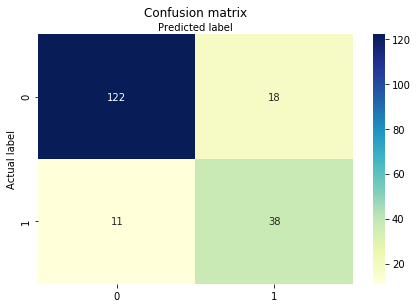

In [210]:
# visualize confusion matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

We can see that the most prevalent classification error is of **False Positives** i.e. when the actual value is negative but the model predicts a positive value. This is also known as **Type 1 error**. Other confusion matrix evaluation metrics have been calculated above.

#### Generate a ROC curve plot.

First, we need the model to return probabilities not predictions.

In [211]:
probs = logreg_cv_mod.predict_proba(std_test_X)
probs = pd.DataFrame(probs,columns=logreg_cv_mod.classes_)
#probs

In [212]:
# Generate the False Positive Rate and True Positive Rate Given different thresholds
fpr, tpr, thresholds = m.roc_curve(test_y, probs[1])

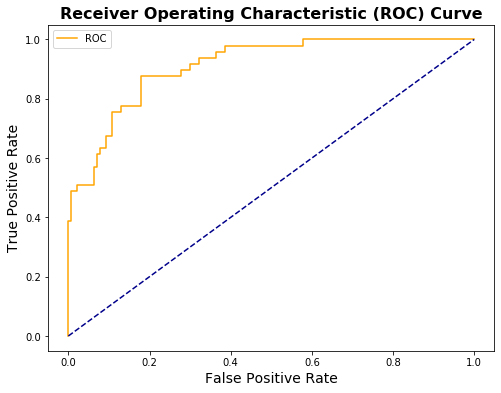

In [213]:
# plot ROC curve
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(8,6)
plt.show()

In [214]:
# Calculate area under ROC curve
print('Area Under Curve:',m.roc_auc_score(test_y,logreg_cv_mod.predict_proba(std_test_X)[:,1]))

Area Under Curve: 0.9115160349854228


### Determining Feature Importance

#### Feature Importance with `eli5`

Initialize the PermutationImportance class object.

In [215]:
perm_train = PermutationImportance(logreg_cv_mod,
                                   n_iter=5,random_state=123)

Fit it using the train (or test!) data

In [216]:
perm_train.fit(X_train,y_train)

PermutationImportance(estimator=LogisticRegression(C=0.30000000000000004,
                                                   penalty='l1',
                                                   solver='liblinear'),
                      random_state=123)

In [217]:
vi2 = eli5.explain_weights_df(perm_train,feature_names = list(train_X))

# view vi2
#vi2

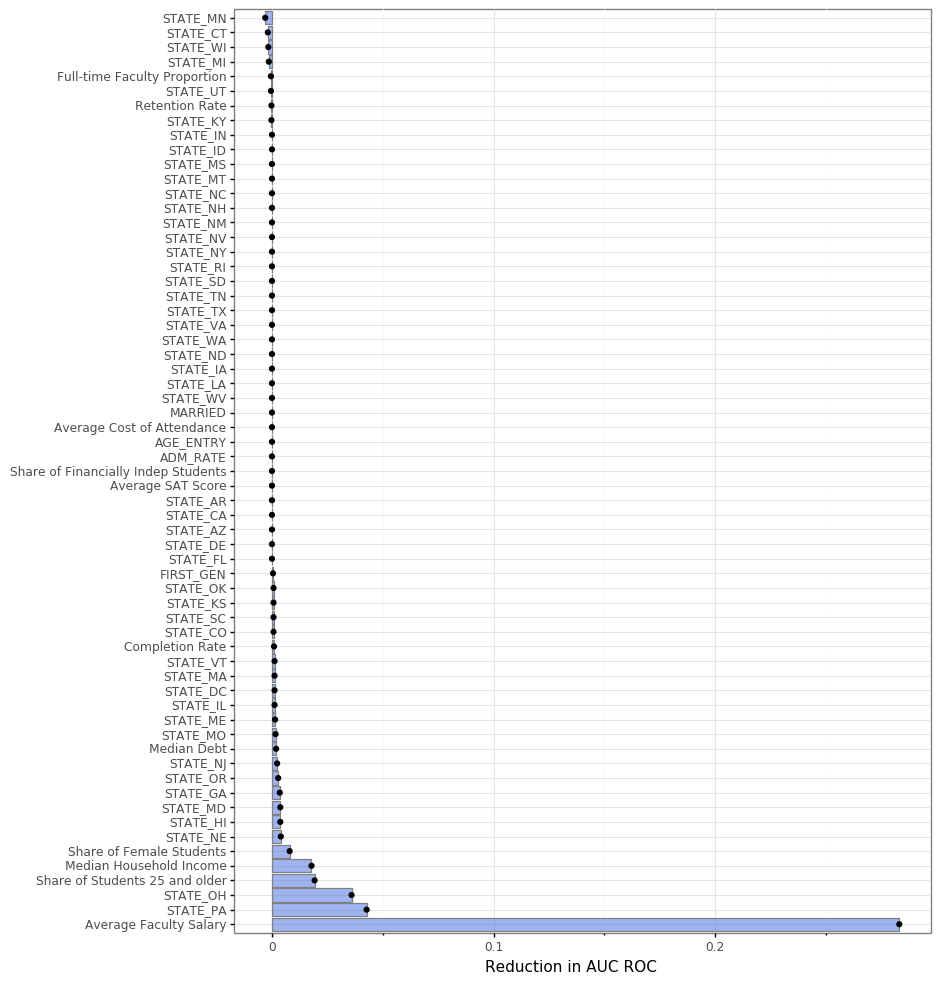

<ggplot: (-9223371866676873508)>

In [218]:
# Plot
plot_vi2_ = (
    ggplot(vi2,
          aes(x="feature",y="weight")) +
    geom_col(alpha=.5,fill="royalblue", color="gray") +
    geom_point() +
    theme_bw() + 
    scale_x_discrete(limits=vi2.feature.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")+
    theme(figure_size=(9, 12))
)

# save plot
plot_vi2_.save("plot_vi2_.png", dpi =300)

# view plot
plot_vi2_

Most important feature is average faculty salary, followed by Pennsylvania state, Ohio state, the percentage of undergraduates aged 25 and above and median household income.

In [219]:
# store top 5 most important variables in separate dataframe
vi2_top = vi2.loc[:4,:]

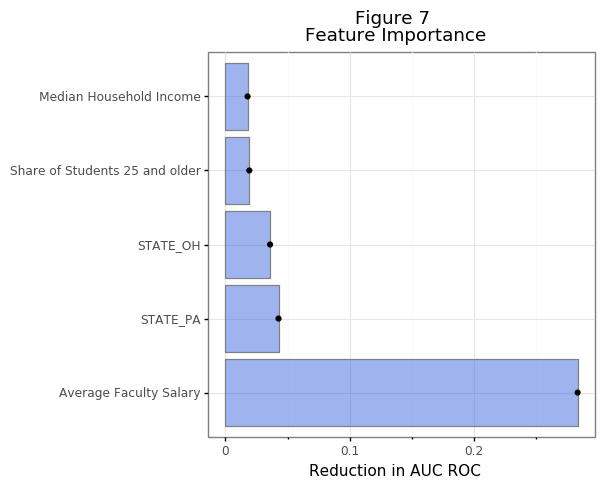

<ggplot: (-9223371866676294592)>

In [220]:
# Plot top 5 most important variables
plot_vi2_top5_priv = (
    ggplot(vi2_top,
          aes(x="feature",y="weight")) +
    geom_col(alpha=.5,fill="royalblue", color="gray") +
    geom_point() +
    theme_bw() + 
    scale_x_discrete(limits=vi2_top.feature.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="",title="Figure 7 \nFeature Importance")+
    theme(figure_size=(5, 5))
)

# save plot
plot_vi2_top5_priv.save("plot_vi2_top5_priv.png", dpi =300)

# view plot
plot_vi2_top5_priv

#### Check Coefficients

In [221]:
# separate target and predictors
y = df3[['earnings_25pct']]
X = df3.drop(columns=['earnings_25pct'])

In [222]:
# flatten 2-D array
logreg_coefs = logreg_cv_mod.coef_.flatten()

In [223]:
# view coefficients
df_llr_coefs = pd.DataFrame({'Variable': X.columns, 'Coef': logreg_coefs})
df_llr_coefs
df_llr_coefs = df_llr_coefs.sort_values('Coef', ascending = False)
df_llr_coefs = df_llr_coefs.reset_index(drop=True)

# view first 10 rows
df_llr_coefs.loc[:10,:]

,Variable,Coef
0,Average Faculty Salary,2.573159
1,Share of Students 25 and older,0.673904
2,Median Household Income,0.649394
3,STATE_PA,0.606257
4,STATE_OH,0.394695
5,STATE_CO,0.237260
6,STATE_MI,0.207494
7,STATE_OK,0.206576
8,STATE_NE,0.201599
9,Share of Female Students,0.194167


The most important variables are average faculty salary, share of students 25 and older and median household income.

In [224]:
# count the number of coefficients being zeroed out
df_llr_coefs[df_llr_coefs == 0].count(axis=1).sum()

25

25 coefficients were zeroed out.

## <center> <font color="royalblue"> Non-Parametric Model: Decision Tree Classifier

### Hyperparameter Tuning

In [225]:
# separate target and features
y = df3[['earnings_25pct']]
X = df3.drop(columns=['earnings_25pct'])

# split data
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=123)

In [226]:
# parameters
param_dict = {
    "max_depth":range(1,10),
}

In [227]:
# model
decision_tree = DecisionTreeClassifier()

# Run GridSearch
dec_tree = GridSearchCV(decision_tree,
                   param_grid=param_dict,
                   cv=10)

In [228]:
# fit model
dec_tree.fit(train_X,train_y)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(1, 10)})

In [229]:
dec_tree.best_params_

{'max_depth': 3}

Most appropriate max depth = 1

In [230]:
# store best estimator
dtree_mod = dec_tree.best_estimator_
dtree_mod

DecisionTreeClassifier(max_depth=3)

### Test Performance and Model Evaluation
Check how well the best performing model does on the test data that it wasn't trained on.

In [231]:
# Predict() method will use the best model out of the scan
pred_y = dec_tree.predict(test_X)

In [232]:
# Look at evaluation metrics on the test data
print('Area Under Curve:',m.roc_auc_score(test_y,dtree_mod.predict_proba(test_X)[:,1]))
print('Accuracy score:', m.accuracy_score(test_y,pred_y))
print("Precision:",metrics.precision_score(test_y, pred_y))
print('F1 score: ', f1_score(test_y, pred_y))
print('Recall score: ', recall_score(test_y, pred_y))

Area Under Curve: 0.9295918367346939
Accuracy score: 0.8783068783068783
Precision: 0.76
F1 score:  0.7676767676767676
Recall score:  0.7755102040816326


In [233]:
# check overfitting - check performance of training data
# accuracy
print(m.accuracy_score(train_y,dtree_mod.predict(train_X)))

0.8871252204585538


Decision trees are prone to overfitting. However, potential overfitting seems to have been addressed by setting an optimal maximum tree depth based on a grid search/validation curves. 

#### Confusion Matrix

#### <center> <font color='darkblue'>Confusion Matrix for the Binary Case</font>

|  | <center> Negative (predicted) | <center> Positive (predicted) |
| ----- | ----- | --- | 
| <center> **Negative (actual)** | <center> True Negatives |  <center> False Positives |
| <center> **Positive (actual)** | <center> False Negatives |  <center> True Positives |

In [234]:
# create confusion matrix
cnf_matrix = metrics.confusion_matrix(test_y, pred_y)
cnf_matrix

array([[128,  12],
       [ 11,  38]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

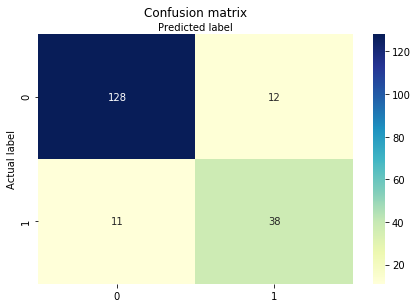

In [235]:
# visualize confusion matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

We can see that the most prevalent classification error is of **False Positives** i.e. when the actual value is negative but the model predicts a positive value. This is also known as **Type 1 error**. Other confusion matrix evaluation metrics have been calculated above.

#### Generate a ROC curve plot.

First, we need the model to return probabilities not predictions.

In [236]:
probs = dtree_mod.predict_proba(test_X)
probs = pd.DataFrame(probs,columns=dtree_mod.classes_)
#probs

In [237]:
# Generate the False Positive Rate and True Positive Rate Given different thresholds
fpr, tpr, thresholds = m.roc_curve(test_y, probs[1])

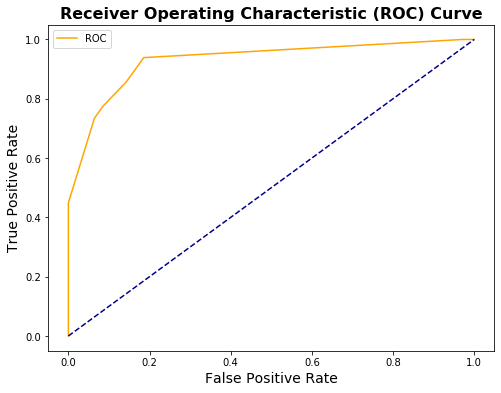

In [238]:
# plot ROC curve
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(8,6)
plt.show()

In [239]:
# Calculate area under ROC curve
print('Area Under Curve:',m.roc_auc_score(test_y,dtree_mod.predict_proba(test_X)[:,1]))

Area Under Curve: 0.9295918367346939


### Determining Feature Importance

#### Feature Importance with `eli5`

Initialize the PermutationImportance class object.

In [240]:
perm_train = PermutationImportance(dtree_mod,
                                   n_iter=5,random_state=123)

Fit it using the train (or test!) data

In [241]:
perm_train.fit(train_X,train_y)

PermutationImportance(estimator=DecisionTreeClassifier(max_depth=3),
                      random_state=123)

In [242]:
vi2 = eli5.explain_weights_df(perm_train,feature_names = list(train_X))

# view top 3 rows
vi2.loc[:2,:]

,feature,weight,std
0,Average Faculty Salary,0.118871,0.014949
1,Average Cost of Attendance,0.081481,0.004083
2,Share of Female Students,0.022928,0.003864


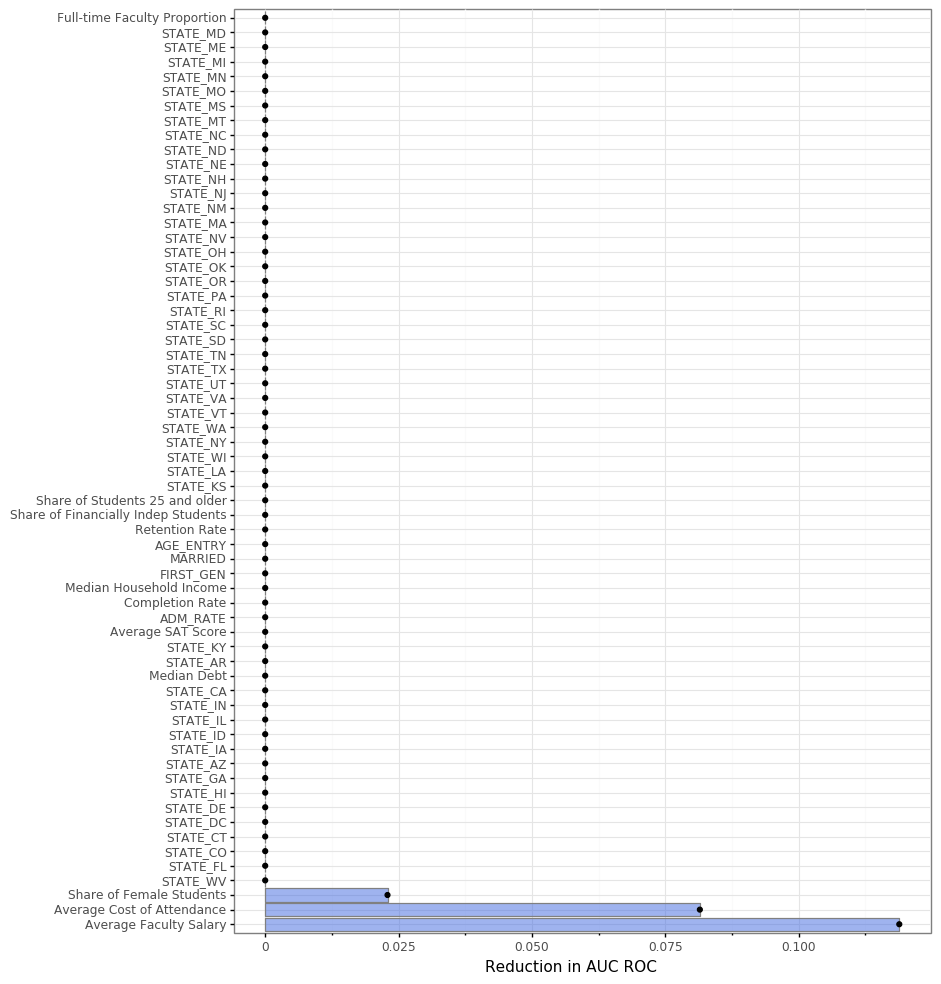

<ggplot: (-9223371866676802584)>

In [243]:
# Plot
plot_vi2_dt_priv = (
    ggplot(vi2,
          aes(x="feature",y="weight")) +
    geom_col(alpha=.5,fill="royalblue", color="gray") +
    geom_point() +
    theme_bw() + 
    scale_x_discrete(limits=vi2.feature.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")+
    theme(figure_size=(9, 12))
)

# save plot
plot_vi2_dt_priv.save("plot_vi2_dt_priv.png", dpi =300)

# view plot
plot_vi2_dt_priv

The most important features are average faculty salary, average cost of attendance, the share of female students, and the share of married students. 

In [244]:
# store most important variables in separate dataframe
vi2_top = vi2.loc[:2,:]

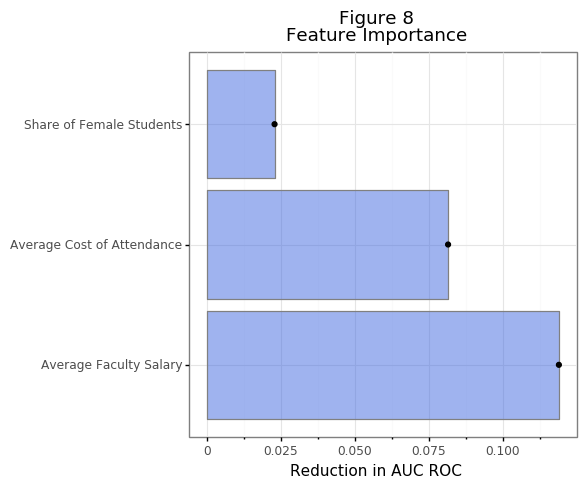

<ggplot: (-9223371866800883776)>

In [245]:
# Plot
plot_vi2_top3_dt_priv = (
    ggplot(vi2_top,
          aes(x="feature",y="weight")) +
    geom_col(alpha=.5,fill="royalblue", color="gray") +
    geom_point() +
    theme_bw() + 
    scale_x_discrete(limits=vi2_top.feature.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="",title="Figure 8\nFeature Importance")+
    theme(figure_size=(5, 5))
)

# save plot
plot_vi2_top3_dt_priv.save("plot_vi2_top3_priv.png", dpi =300)

# view plot
plot_vi2_top3_dt_priv

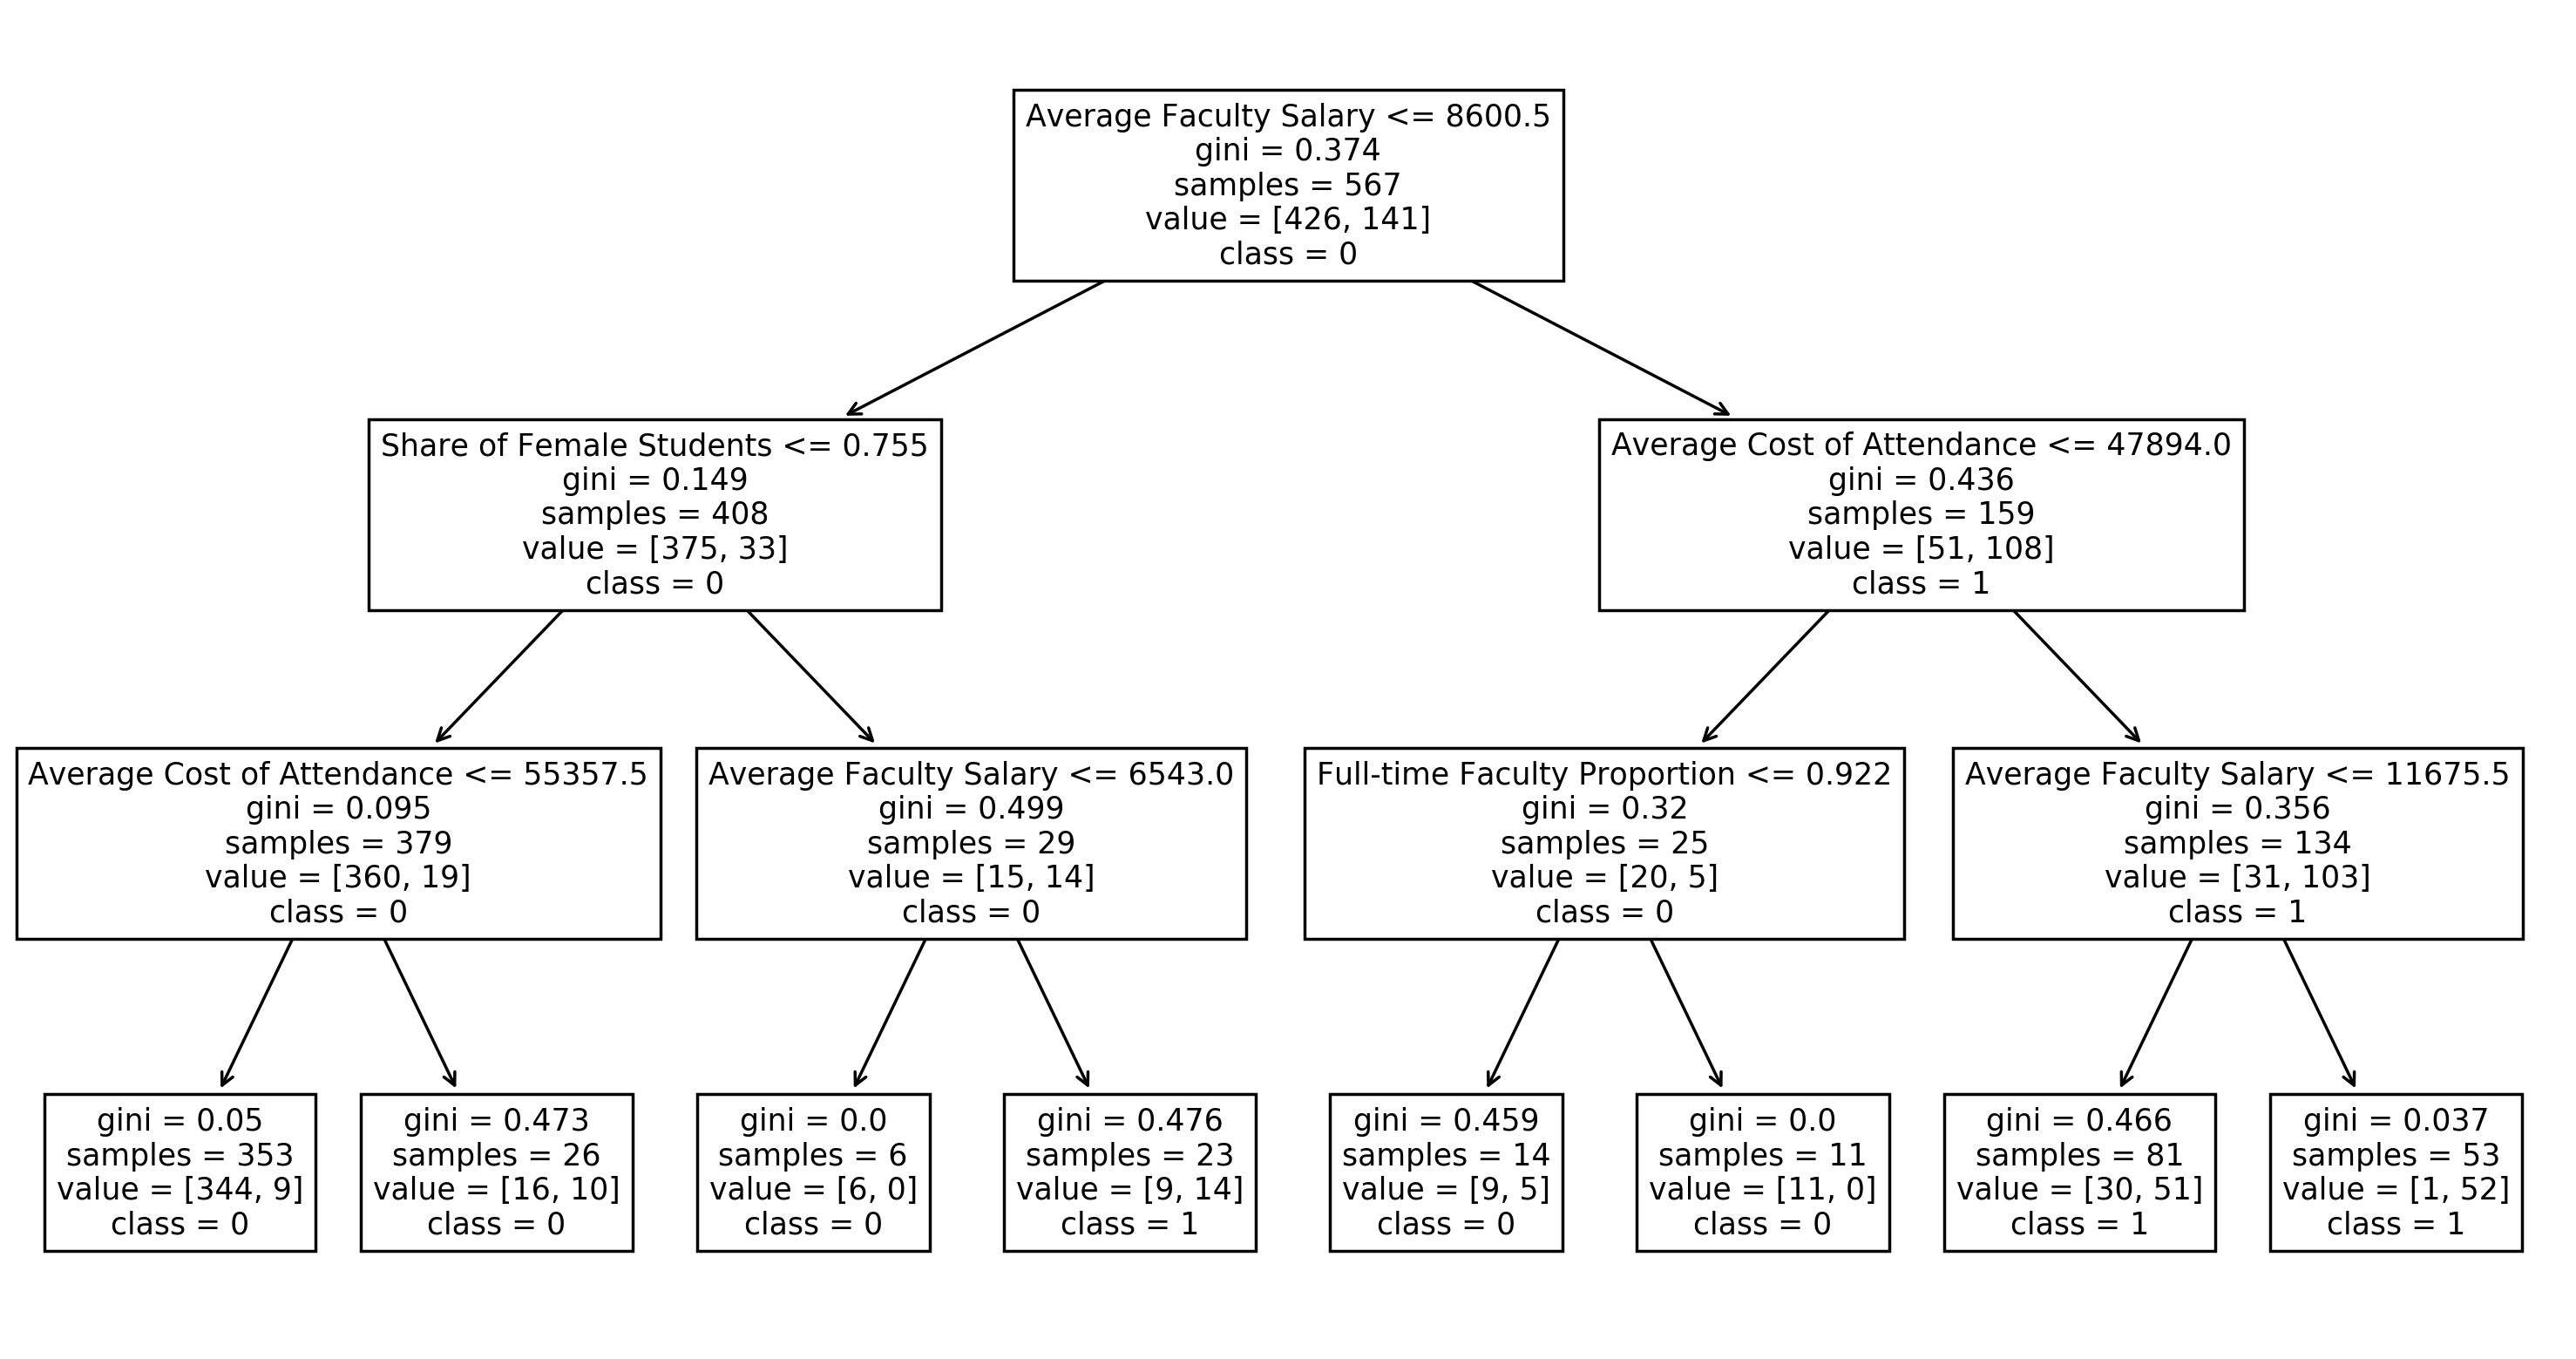

In [246]:
# view the target
list(set(test_y.earnings_25pct))

# store as str to use to visualize tree
names = ['0','1']

# visualize tree
plt.figure(figsize=(15, 8),dpi=250)
plot_tree(dtree_mod, feature_names = train_X.columns, 
          class_names = names, fontsize = 10)
plt.show()

If average faculty salary is less than or equal to $8601, the share of female students is greater than 75.5%, and the share of married students is less than or equal to 21.9%, student earnings are predicted to be in the top quartile.